## 0.0. IMPORTS

In [122]:
import random
import pandas as pd
import numpy as np
import inflection
import math
import xgboost as xgb
import warnings
import seaborn as sns
import pickle
import json
import requests

from matplotlib import pyplot as plt
from tabulate import tabulate
from IPython.core.display import HTML
from IPython.display import Image
from dython.nominal import cramers_v
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, Lasso
from boruta import BorutaPy

warnings.filterwarnings('ignore')

### 0.1. Helper functions

In [35]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display(HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def ml_error (model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse }, index=[0])

def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print( '\nKFold Number: {}'.format(k))
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta (days = k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta (days = (k-1)*6*7)
        
        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
        
        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis = 1)
        ytraining = training['sales']
        
        # validation
        xvalidation = validation.drop(['date', 'sales'], axis = 1)
        yvalidation = validation['sales']
        
        # model
        m = model.fit(xtraining, ytraining)
        
        # prediction
        yhat = m.predict(xvalidation)
        
        # performance
        m_result = ml_error (model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
        
    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])

In [37]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### 0.2. Loading data

In [38]:
df_sales_raw = pd.read_csv('datasets/train.csv', low_memory = False)
df_store_raw = pd.read_csv('datasets/store.csv', low_memory = False)

# merge

df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store') 

## 1.0. PASSO 01 - DESCRICAO DE DADOS

In [39]:
df1 = df_raw.copy()

### 1.1 Rename columns

In [40]:
old_columns = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore (x)

new_columns = list(map(snakecase, old_columns))

# rename columns
df1.columns = new_columns

In [41]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

### 1.2 Data dimension

In [42]:
print (f'Number of Rows: {df1.shape[0]}')
print (f'Number of Cols: {df1.shape[1]}')

Number of Rows: 1017209
Number of Cols: 18


### 1.3 Data types

In [43]:
df1['date'] = pd.to_datetime (df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.4 Check NA

In [44]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5 Fillout NA

In [45]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

#promo_interval
month_map = {1: 'Jan',
2: 'Feb',
3: 'Mar',
4: 'Apr',
5: 'May',
6: 'Jun',
7: 'Jul',
8: 'Aug',
9: 'Sep',
10: 'Oct',
11: 'Nov',
12: 'Dec'}

df1['promo_interval'].fillna(0, inplace = True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

### 1.6 Change Data Types

In [46]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [47]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(np.int64)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(np.int64)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(np.int64)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(np.int64)

### 1.7 Descriptive Statistical

In [48]:
num_attributes = df1.select_dtypes (include = ['float64', 'int64'])
cat_attributes = df1.select_dtypes (exclude = ['float64', 'int64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [49]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 Categorical Attributes

In [50]:
# ver quantos valores há em cada atributo
cat_attributes.apply (lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot: xlabel='assortment', ylabel='sales'>

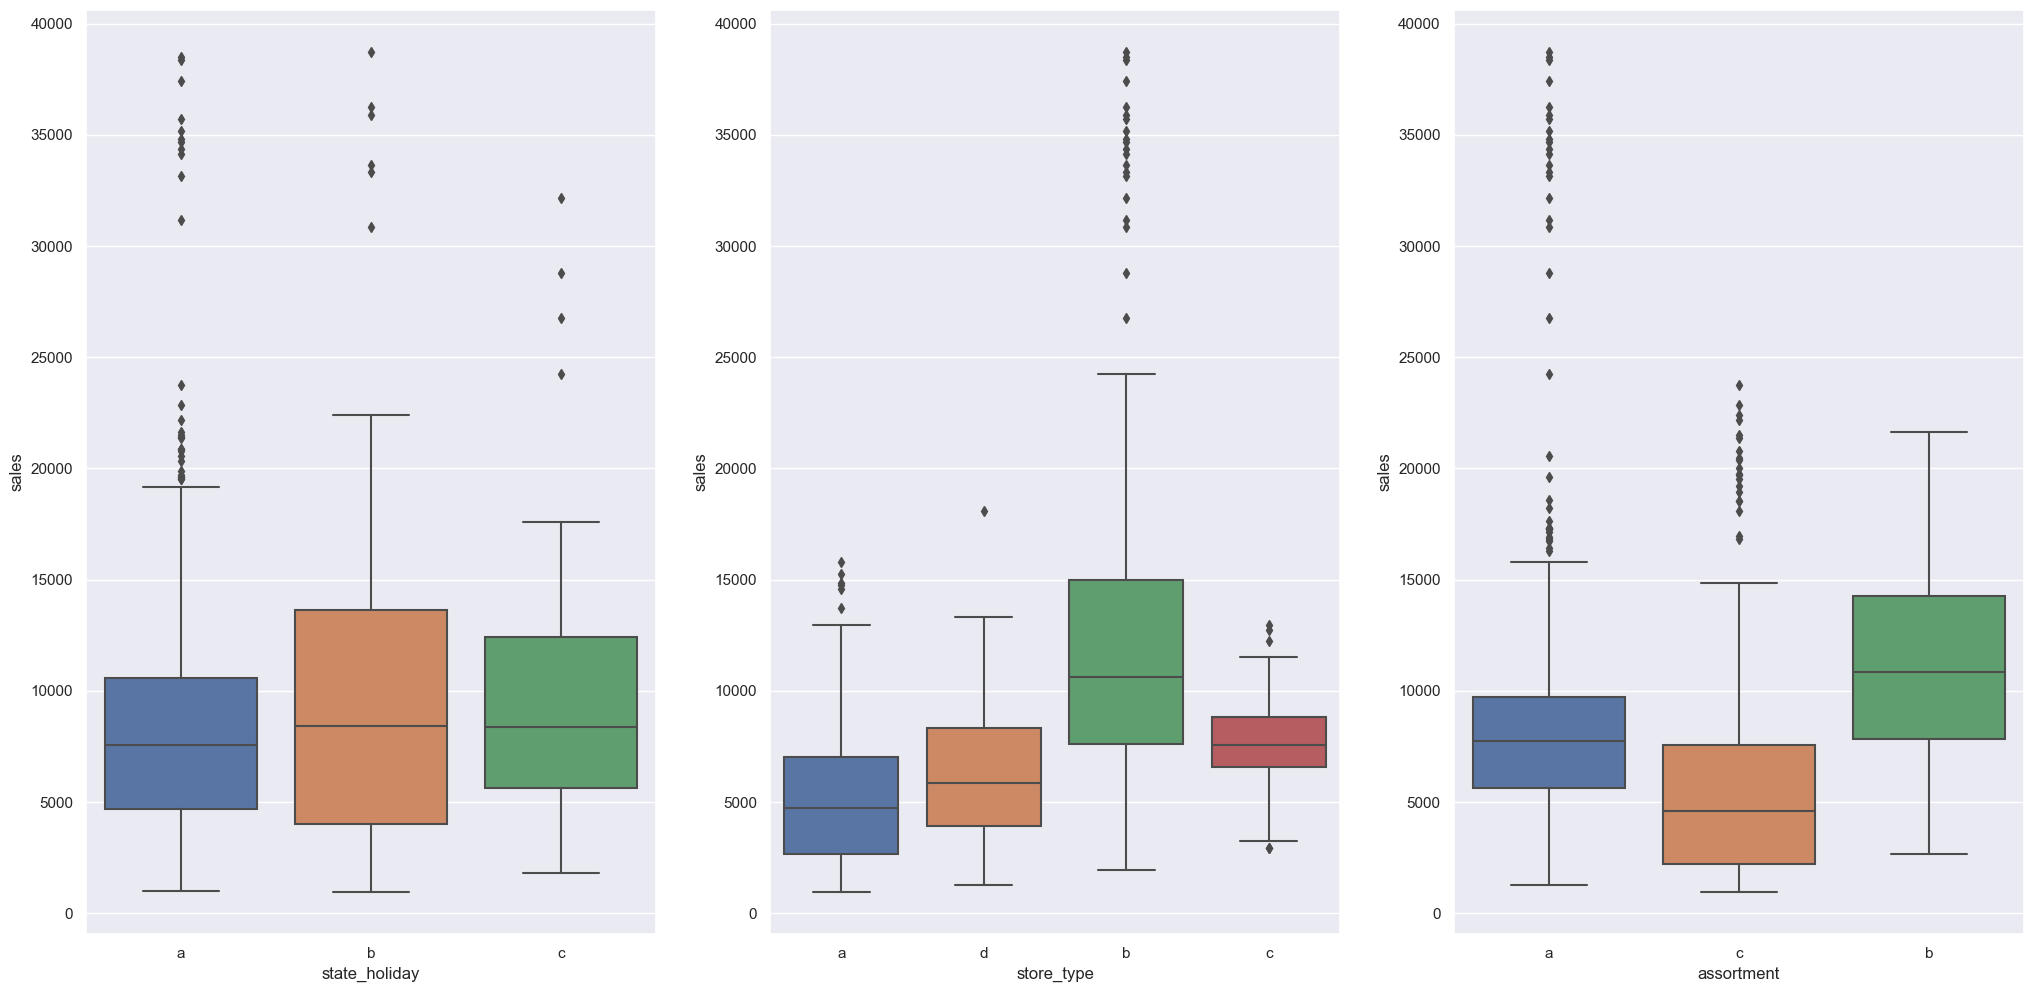

In [51]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot (1, 3, 1)
sns.boxplot (x = 'state_holiday', y = 'sales', data = aux1)

plt.subplot (1, 3, 2)
sns.boxplot (x = 'store_type', y = 'sales', data = aux1)

plt.subplot (1, 3, 3)
sns.boxplot (x = 'assortment', y = 'sales', data = aux1)

## 2.0. Passo 02 - FEATURE ENGINEERING

In [52]:
df2 = df1.copy()

### 2.1. Mapa Mental de Hipóteses

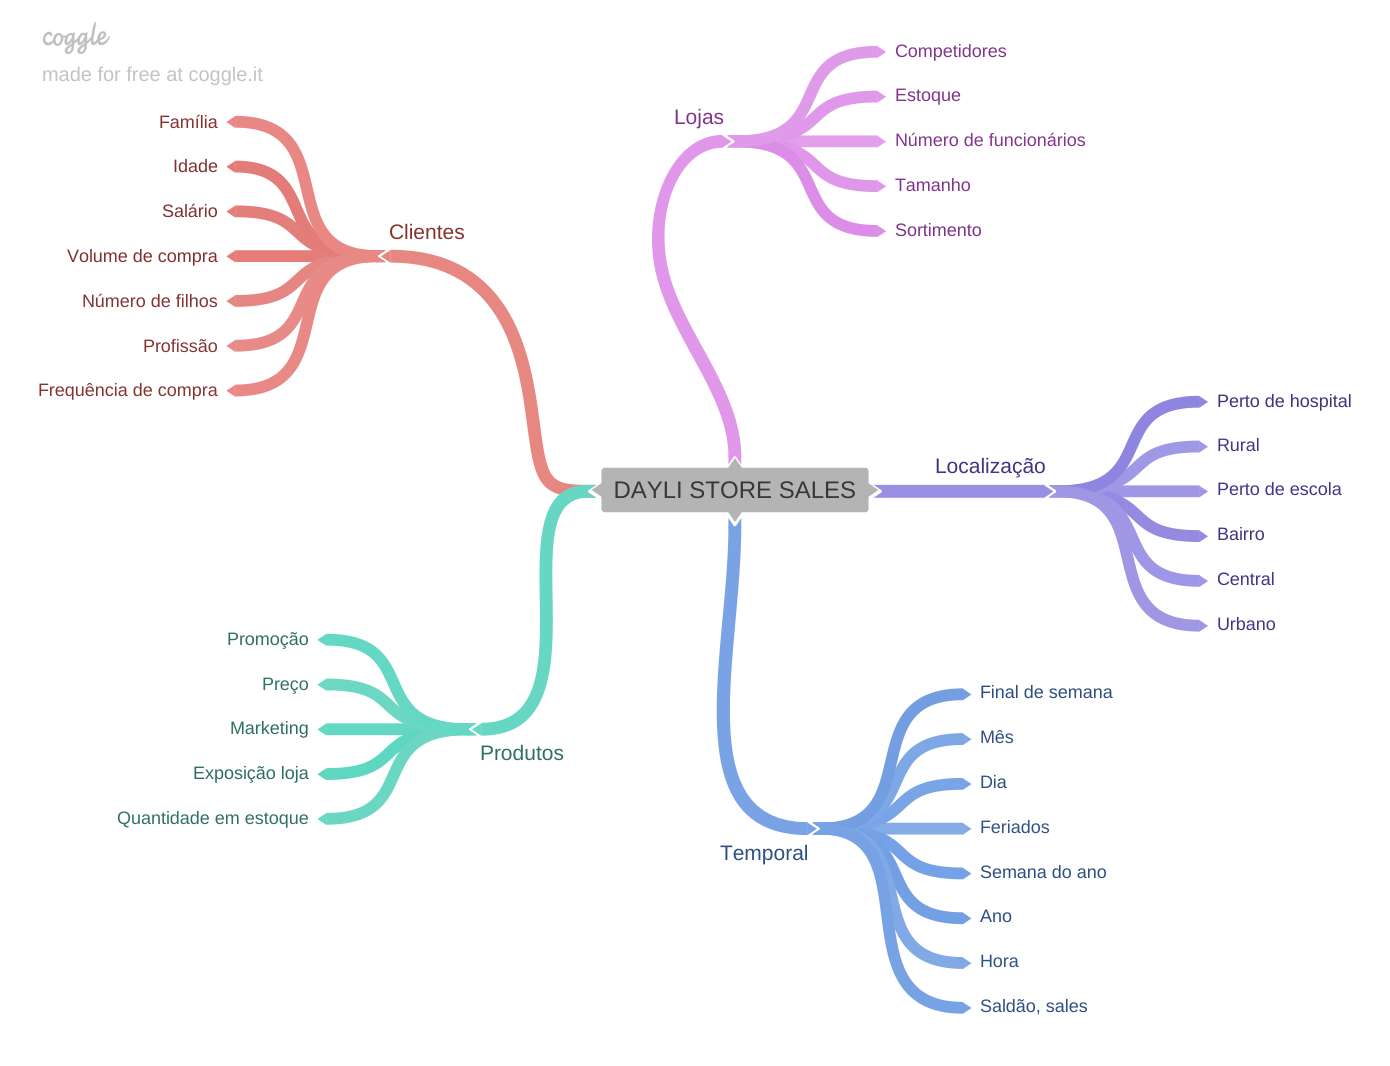

In [54]:
Image('img/DAYLI_STORE_SALES.png')

### 2.2. Criação das Hipóteses

#### 2.2.1 Hipóteses Loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores próximos deveriam vender menos.

**6.** Lojas com competidores a mais tempo deveriam vender menos.

#### 2.2.2 Hipóteses Produto

**1.** Lojas com maior investimento em marketing deveriam vender mais.

**2.** Lojas com maior exposição de produtos nas vitrines deveriam vender mais.

**3.** Lojas com preços menores deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais.

**5.** Lojas com promoções ativas durante mais tempo deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

#### 2.2.3 Hipóteses Tempo

**1.** Lojas abertas durante o Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender mais nos fins de semana.

**6.** Lojas deveriam vender menos durante férias escolares.

### 2.3. Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender menos.

**4.** Lojas com promoções ativas durante mais tempo deveriam vender mais.

**5.** Lojas com mais promoções consecutivas deveriam vender mais.

**6.** Lojas abertas durante o Natal deveriam vender mais.

**7.** Lojas deveriam vender mais ao longo dos anos.

**8.** Lojas deveriam vender mais no segundo semestre do ano.

**9.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**10.** Lojas deveriam vender mais nos fins de semana.

**11.** Lojas deveriam vender menos durante férias escolares.

### 2.4. Feature Engineering

In [55]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype(np.int64)

# year week
df2['year_week'] = df2['date'].dt.strftime ('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'] )/30).apply(lambda x: x.days).astype(np.int64)

# promotion since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days).astype(np.int64)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [56]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int64
month        

## Passo 03 - 3.0. FILTRAGEM DE VARIÁVEIS

In [57]:
df3 = df2.copy()

### 3.1. Filtragem das linhas

In [58]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

### 3.2. Filtragem das colunas

In [59]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

## Passo 04 - 4.0. ANÁLISE EXPLORATÓRIA DE DADOS

In [60]:
df4 = df3.copy()

### 4.1. Análise univariada

#### 4.1.1. Response variable

<AxesSubplot: xlabel='sales', ylabel='Count'>

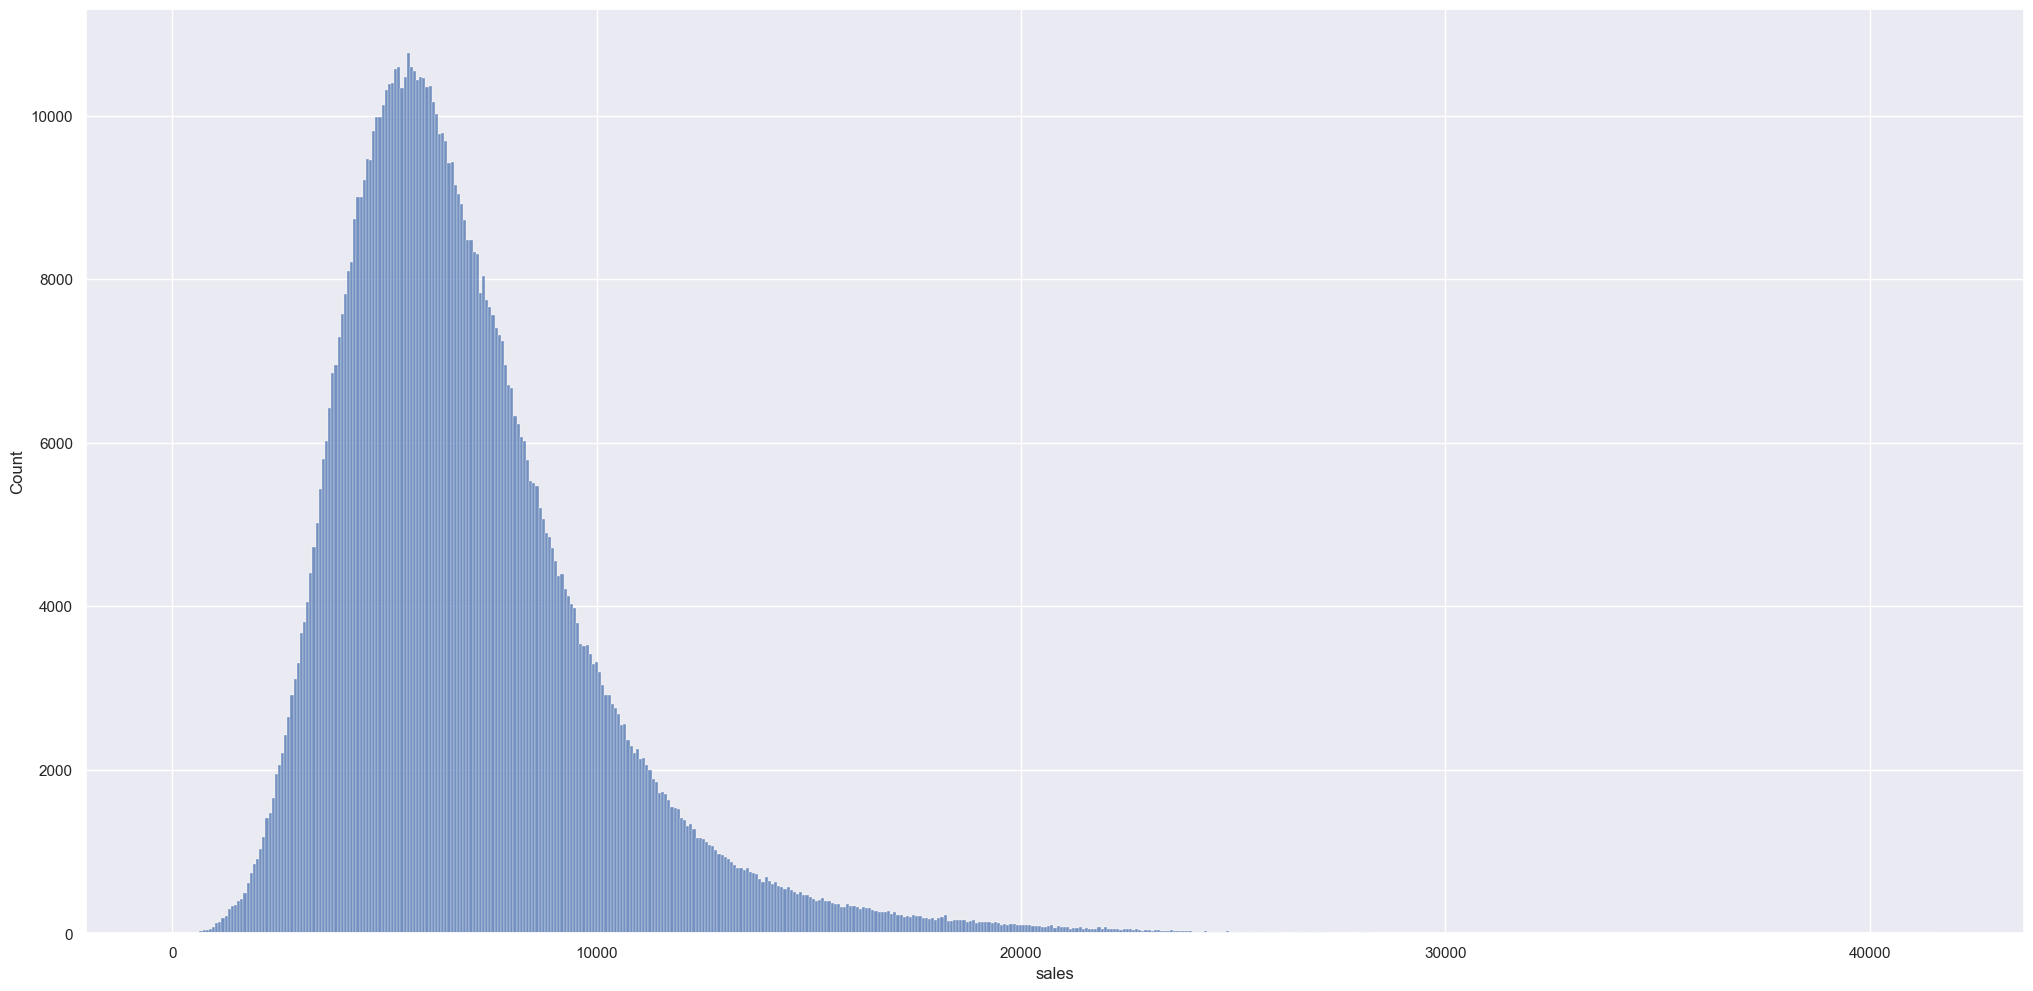

In [61]:
sns.histplot(df4['sales'], kde = False)

#### 4.1.2. Numerical variable

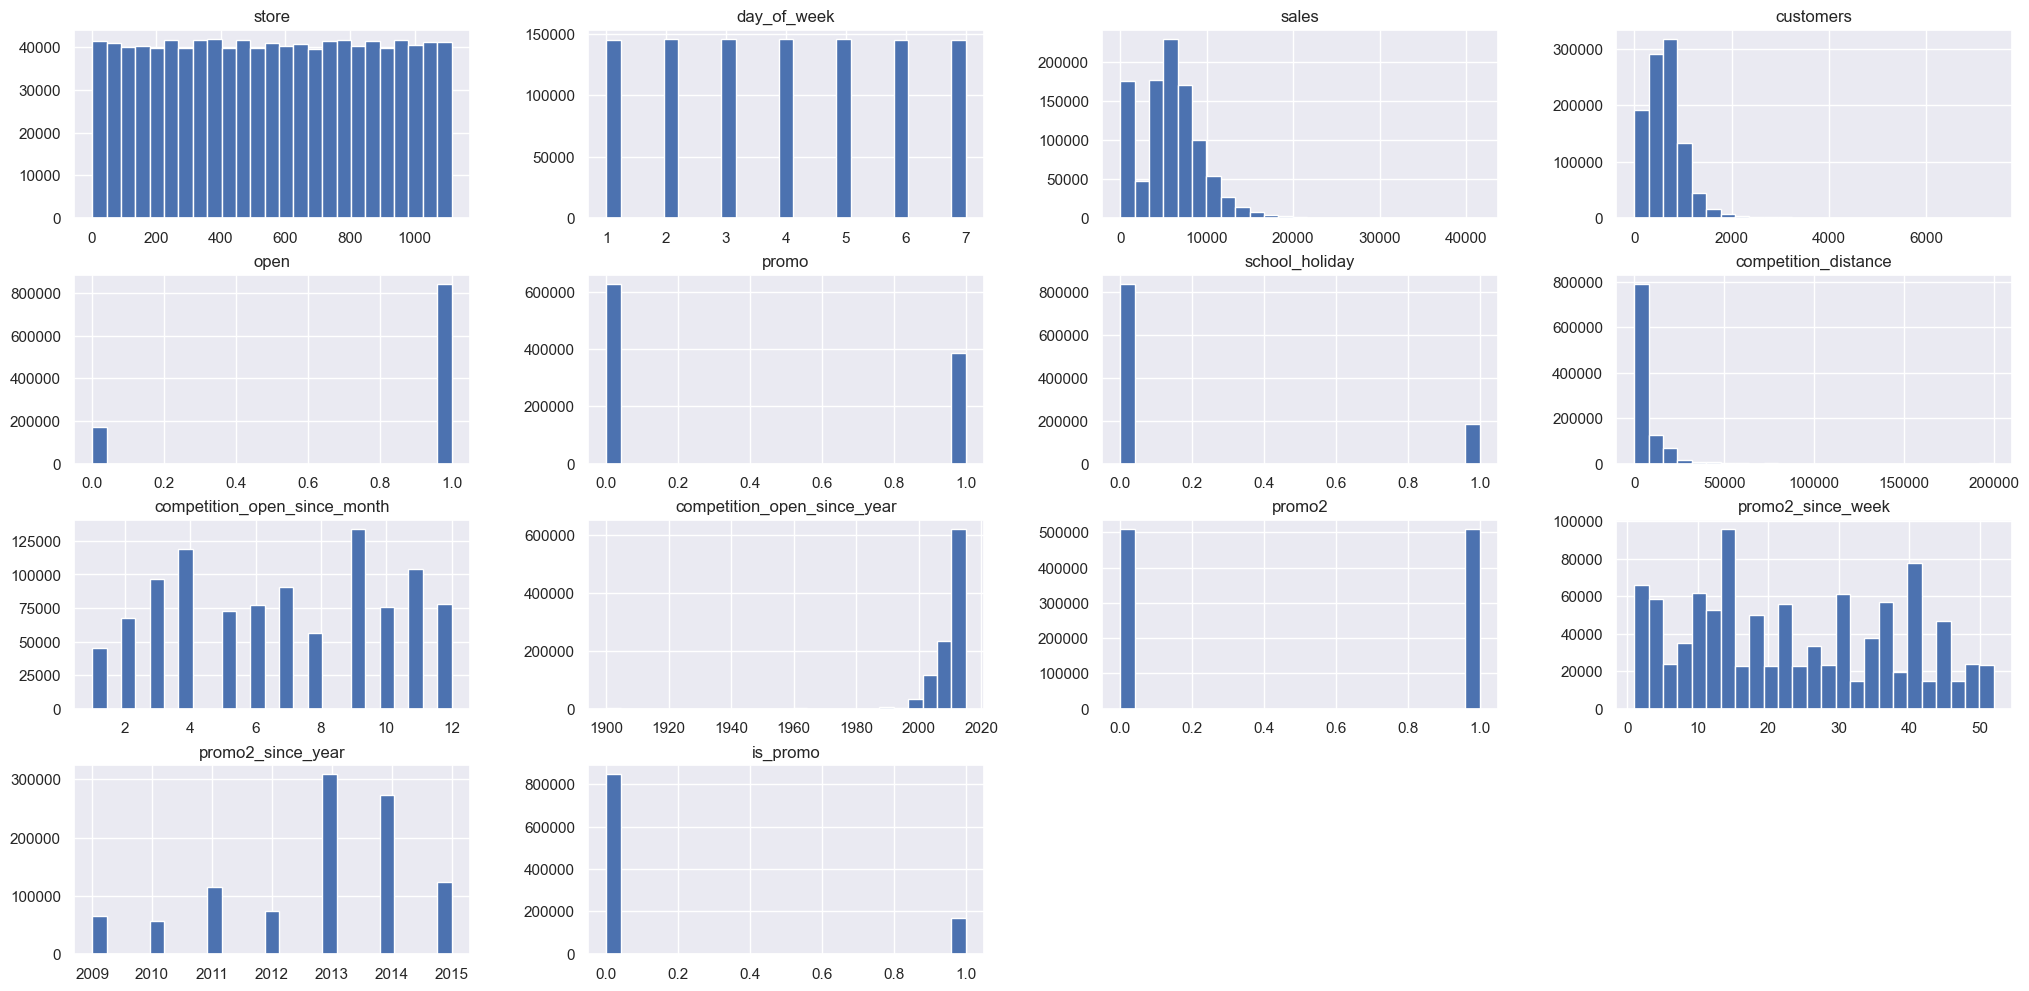

In [62]:
num_attributes.hist (bins = 25);

#### 4.1.3. Categorical variable

In [63]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

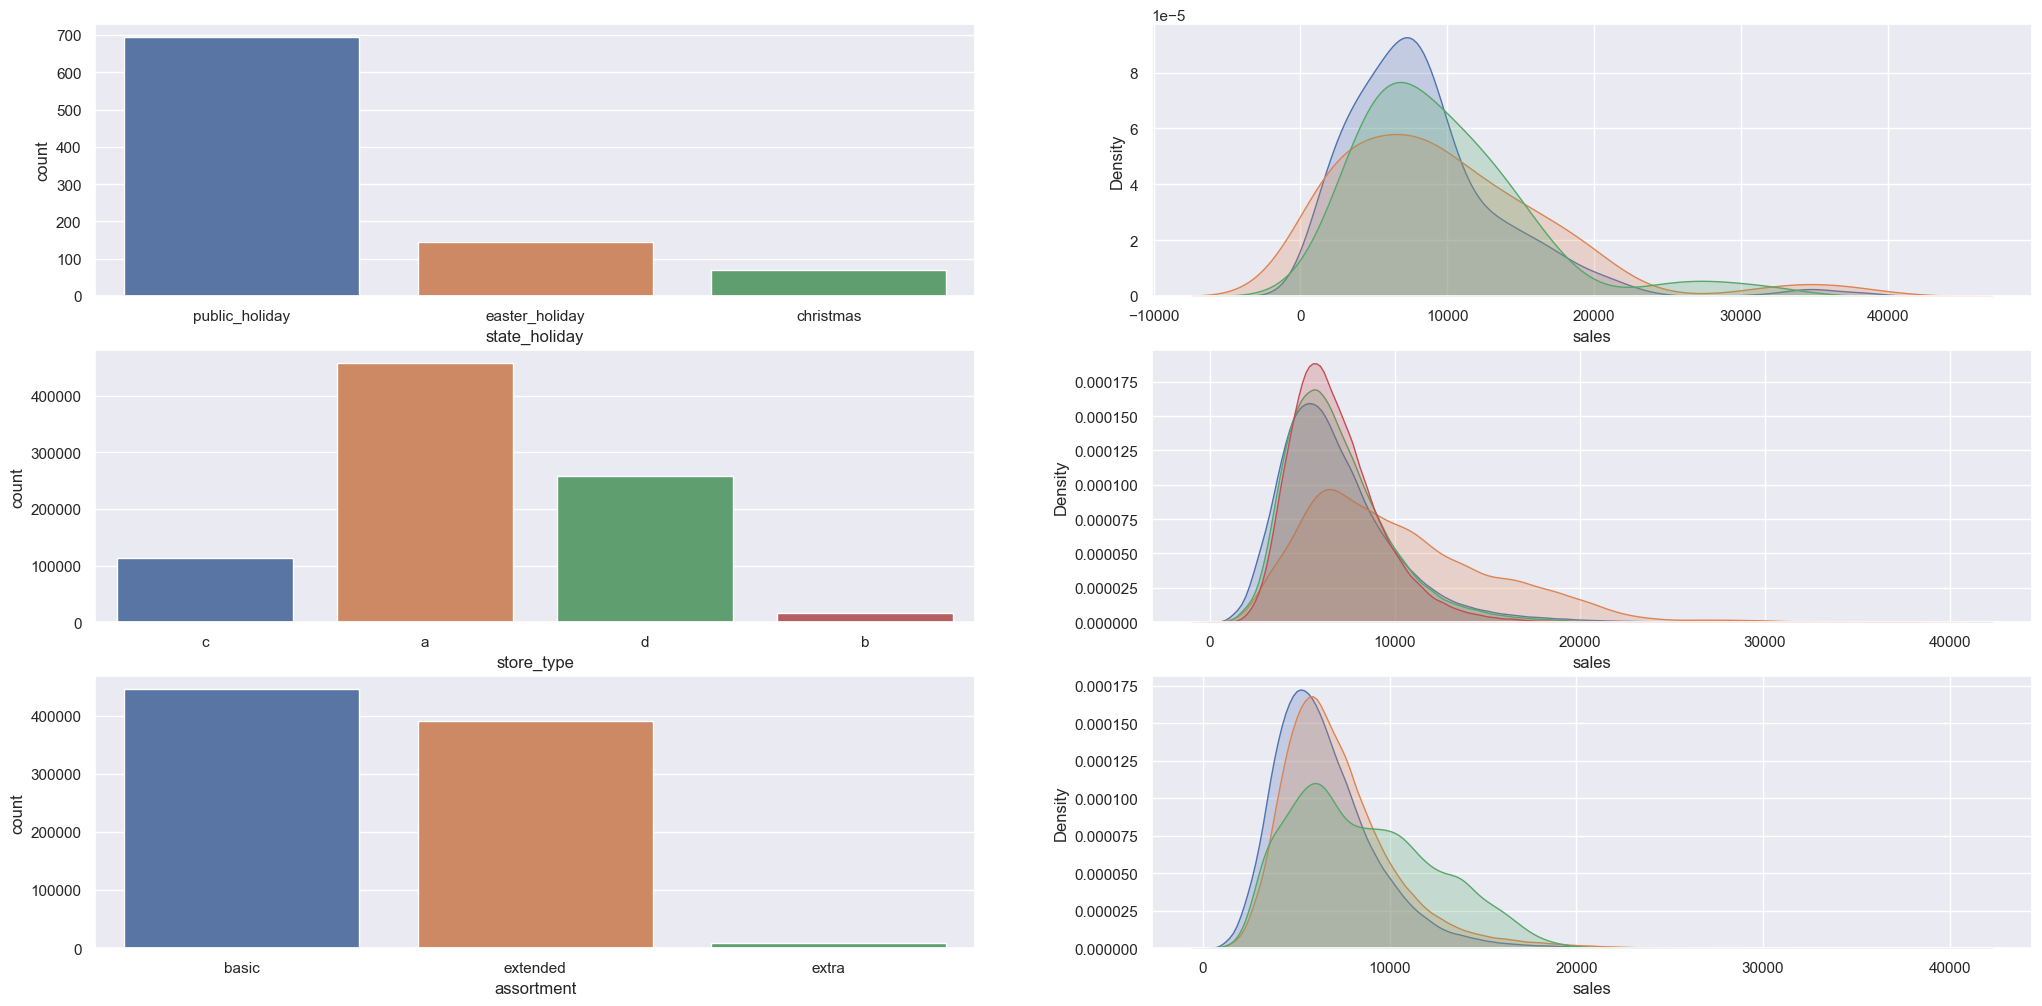

In [65]:
# state_holiday
a = df4[df4['state_holiday'] != 'regular_day']
plt.subplot (3, 2, 1)
sns.countplot( x = 'state_holiday', data = a )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True)
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True)
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True)

# store_type
plt.subplot (3, 2, 3)
sns.countplot( x = 'store_type', data = df4 )

plt.subplot( 3, 2, 4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', fill=True)
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', fill=True)
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', fill=True)
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', fill=True)

# assortment
plt.subplot (3, 2, 5)
sns.countplot (x = 'assortment', data = df4)

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True);
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True);
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True);

### 4.2. Análise bivariada

#### H1. Lojas com maior sortimento deveriam vender mais.
**VERDADEIRO**

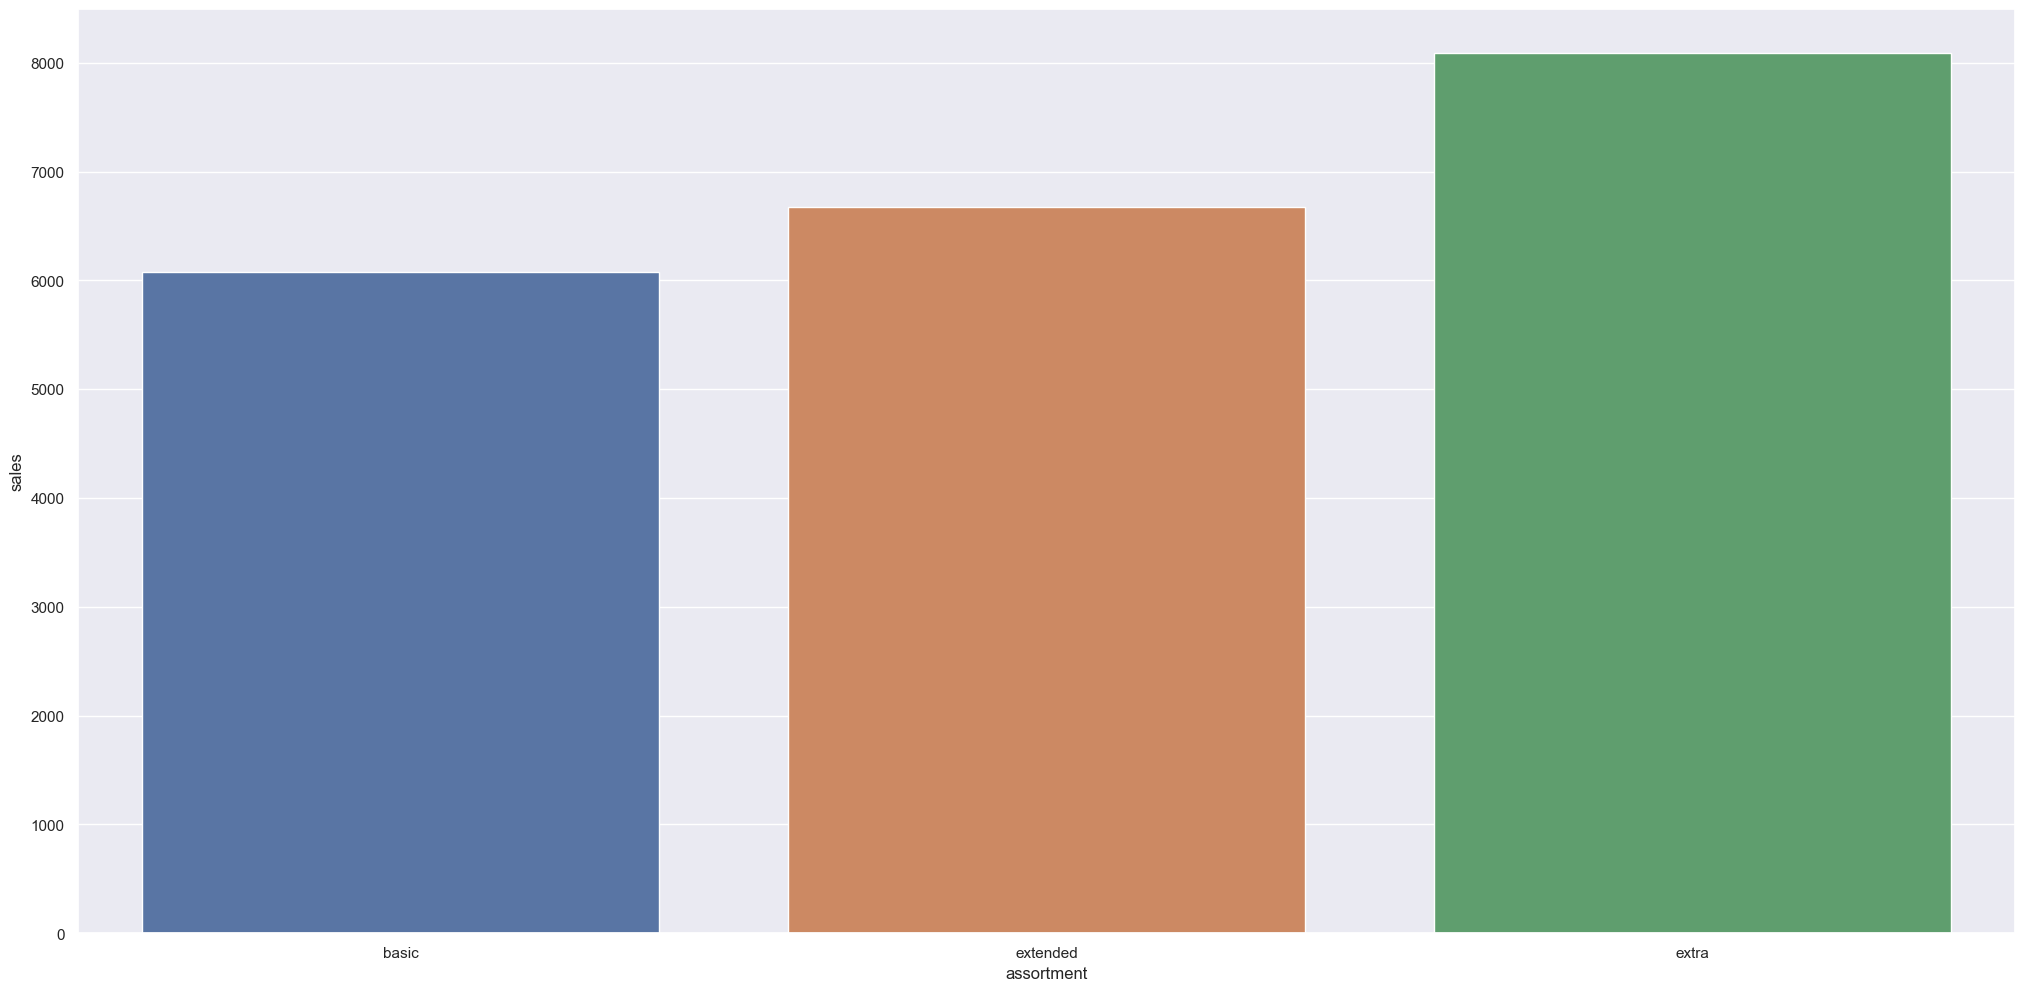

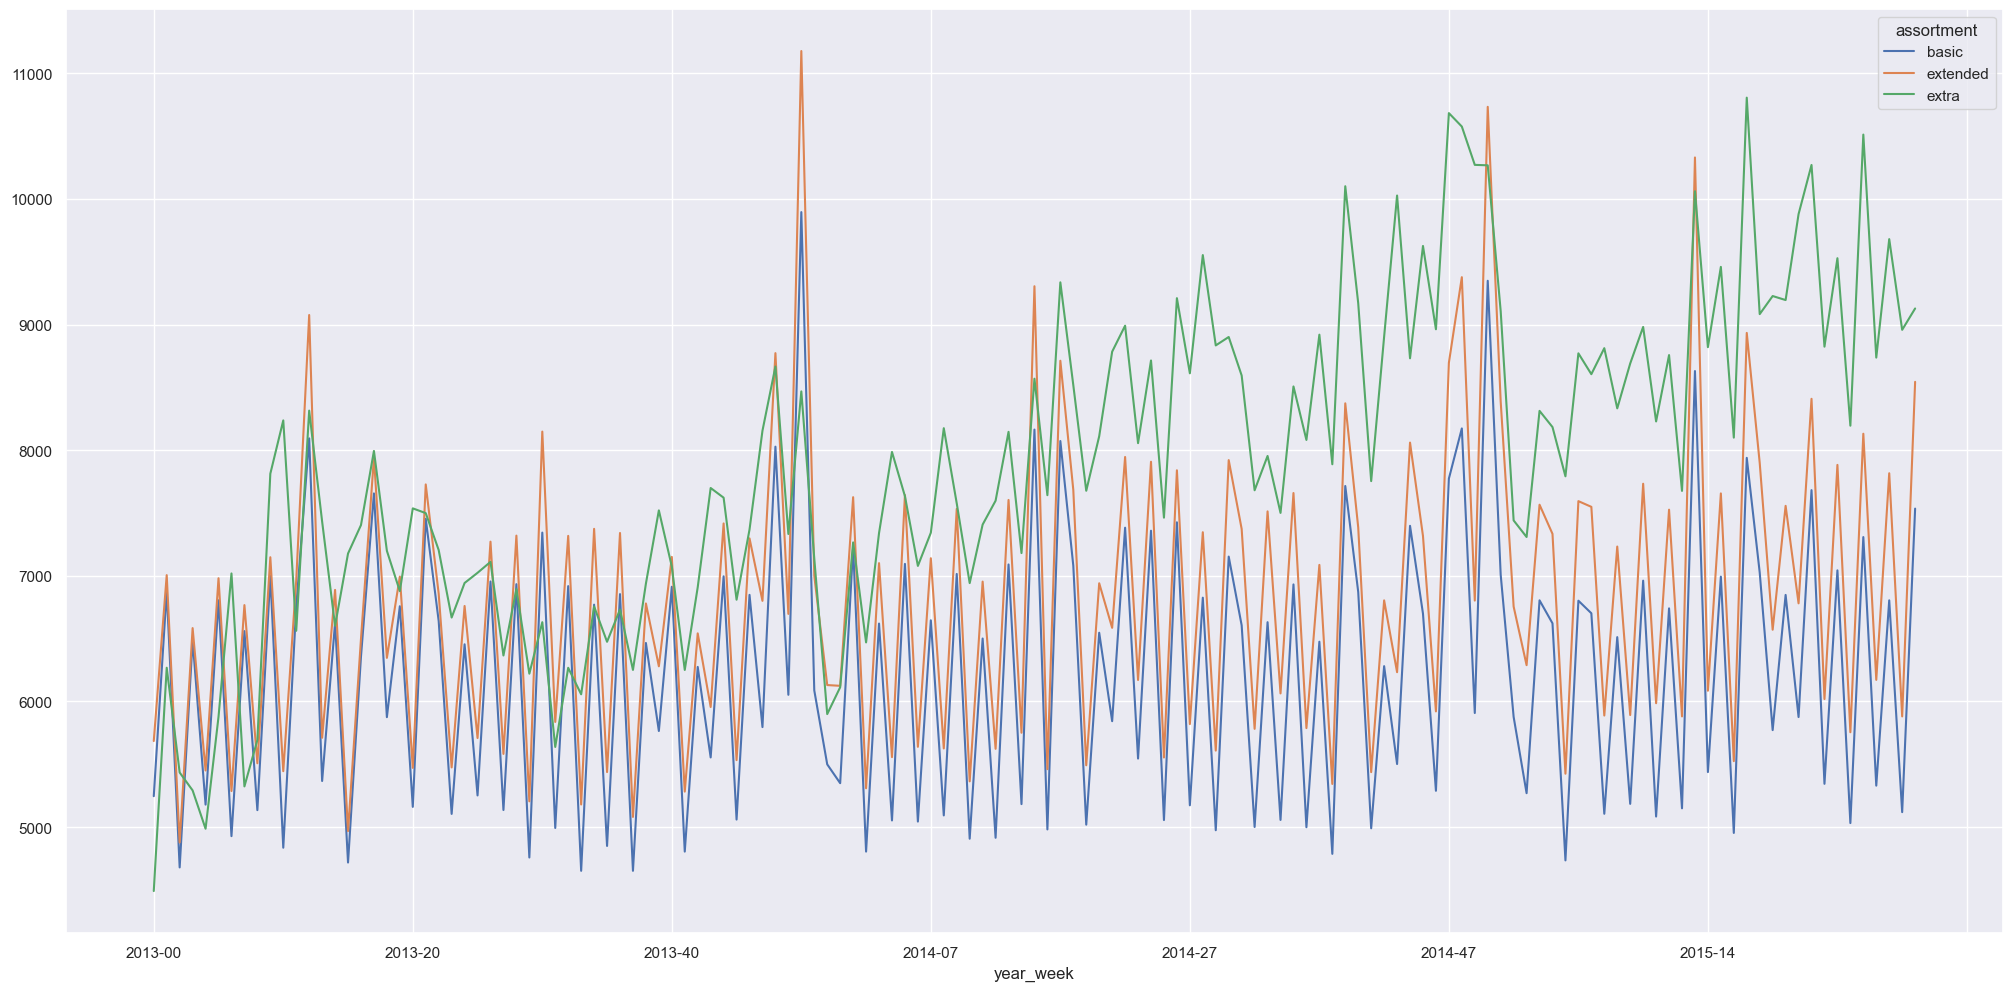

In [66]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').median().reset_index()
sns.barplot (x = 'assortment', y = 'sales', data = aux1);

aux2 = df4[['assortment', 'sales', 'year_week']].groupby(['assortment', 'year_week']).median().reset_index()
aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot();

#### H2. Lojas com competidores próximos deveriam vender menos.
**FALSO** - Não há alteração

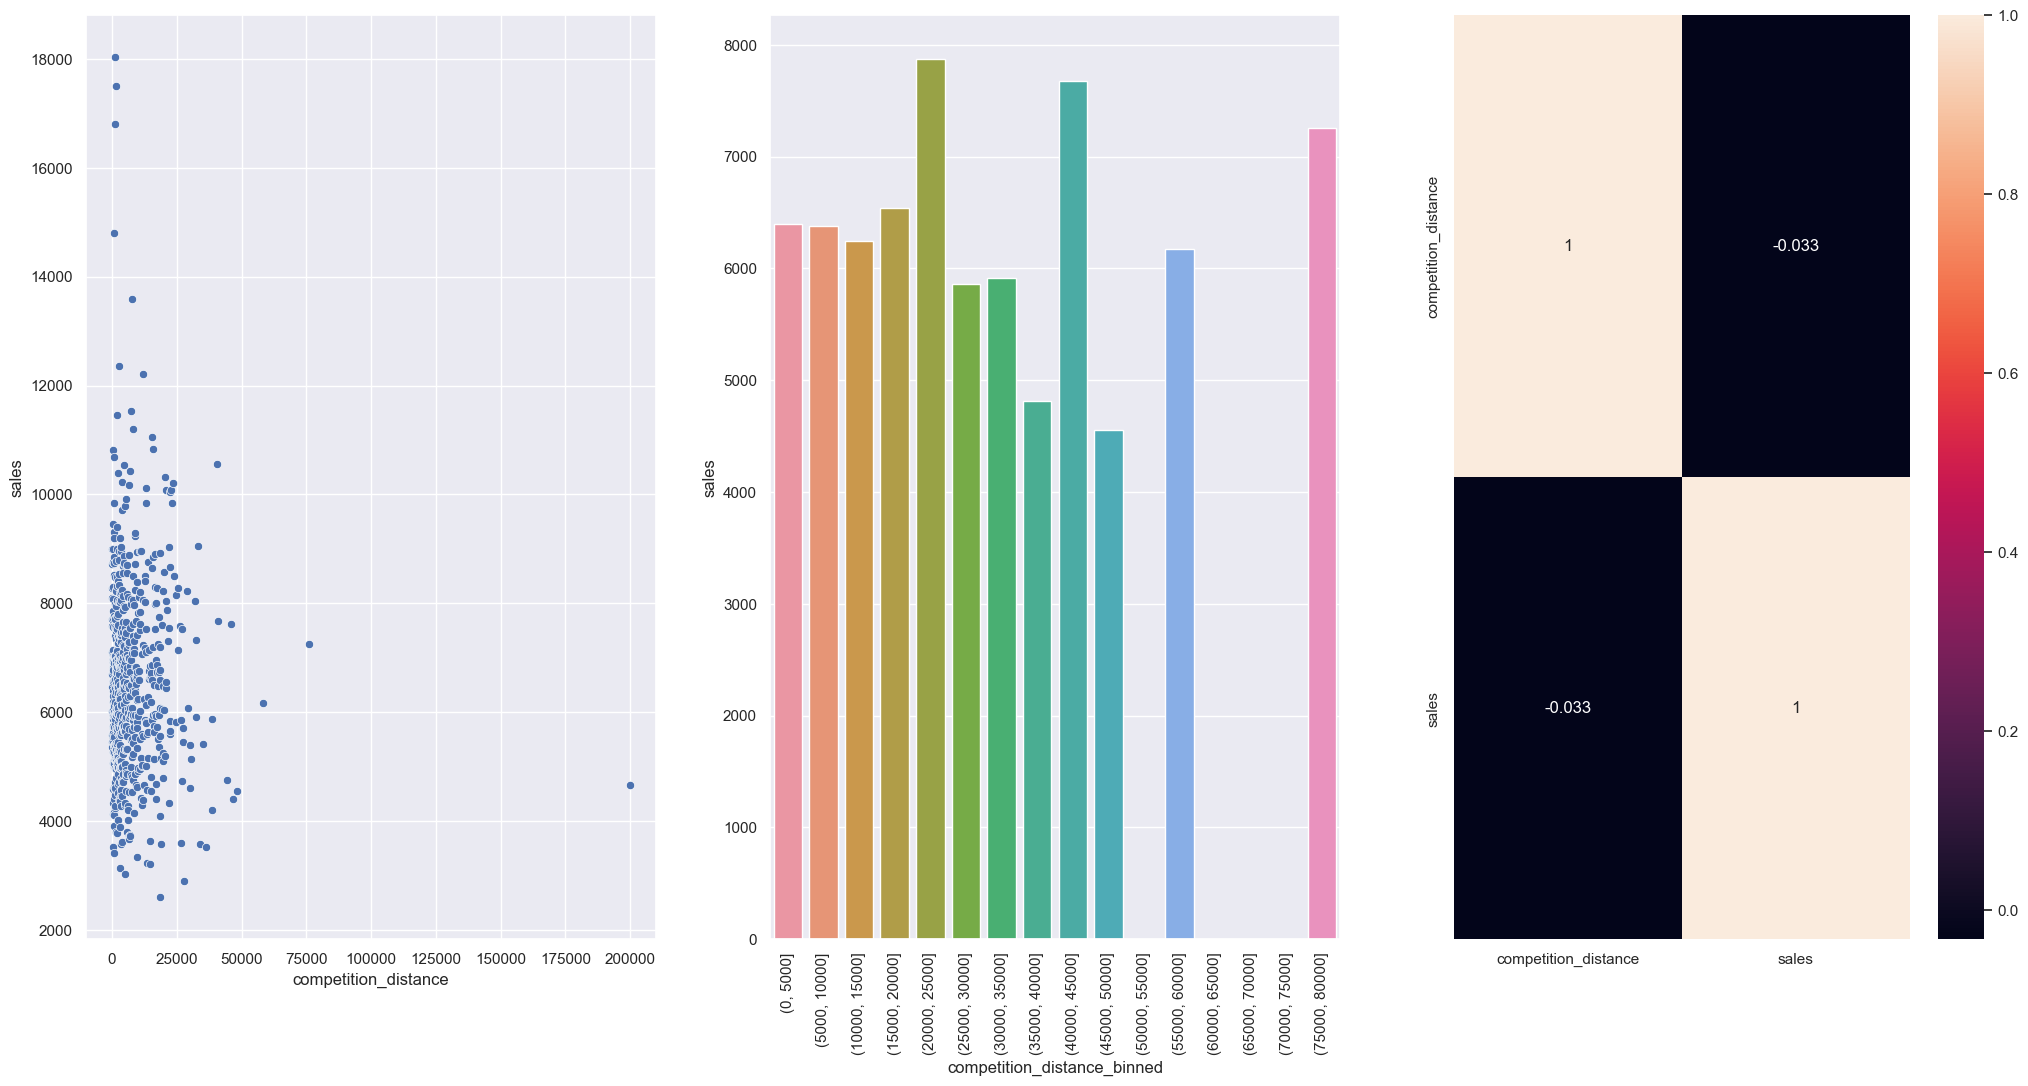

In [67]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').median().reset_index()

plt.subplot (1, 3, 1)
sns.scatterplot (x = 'competition_distance', y = 'sales', data = aux1)

plt.subplot (1, 3, 2)
bins = list(np.arange(0, 80001, 5000))

aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').median().reset_index()

sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot (1, 3, 3)
sns.heatmap (aux1.corr (method = 'pearson'), annot = True);

#### H3. Lojas com competidores a mais tempo deveriam vender menos.
**VERDADEIRO**

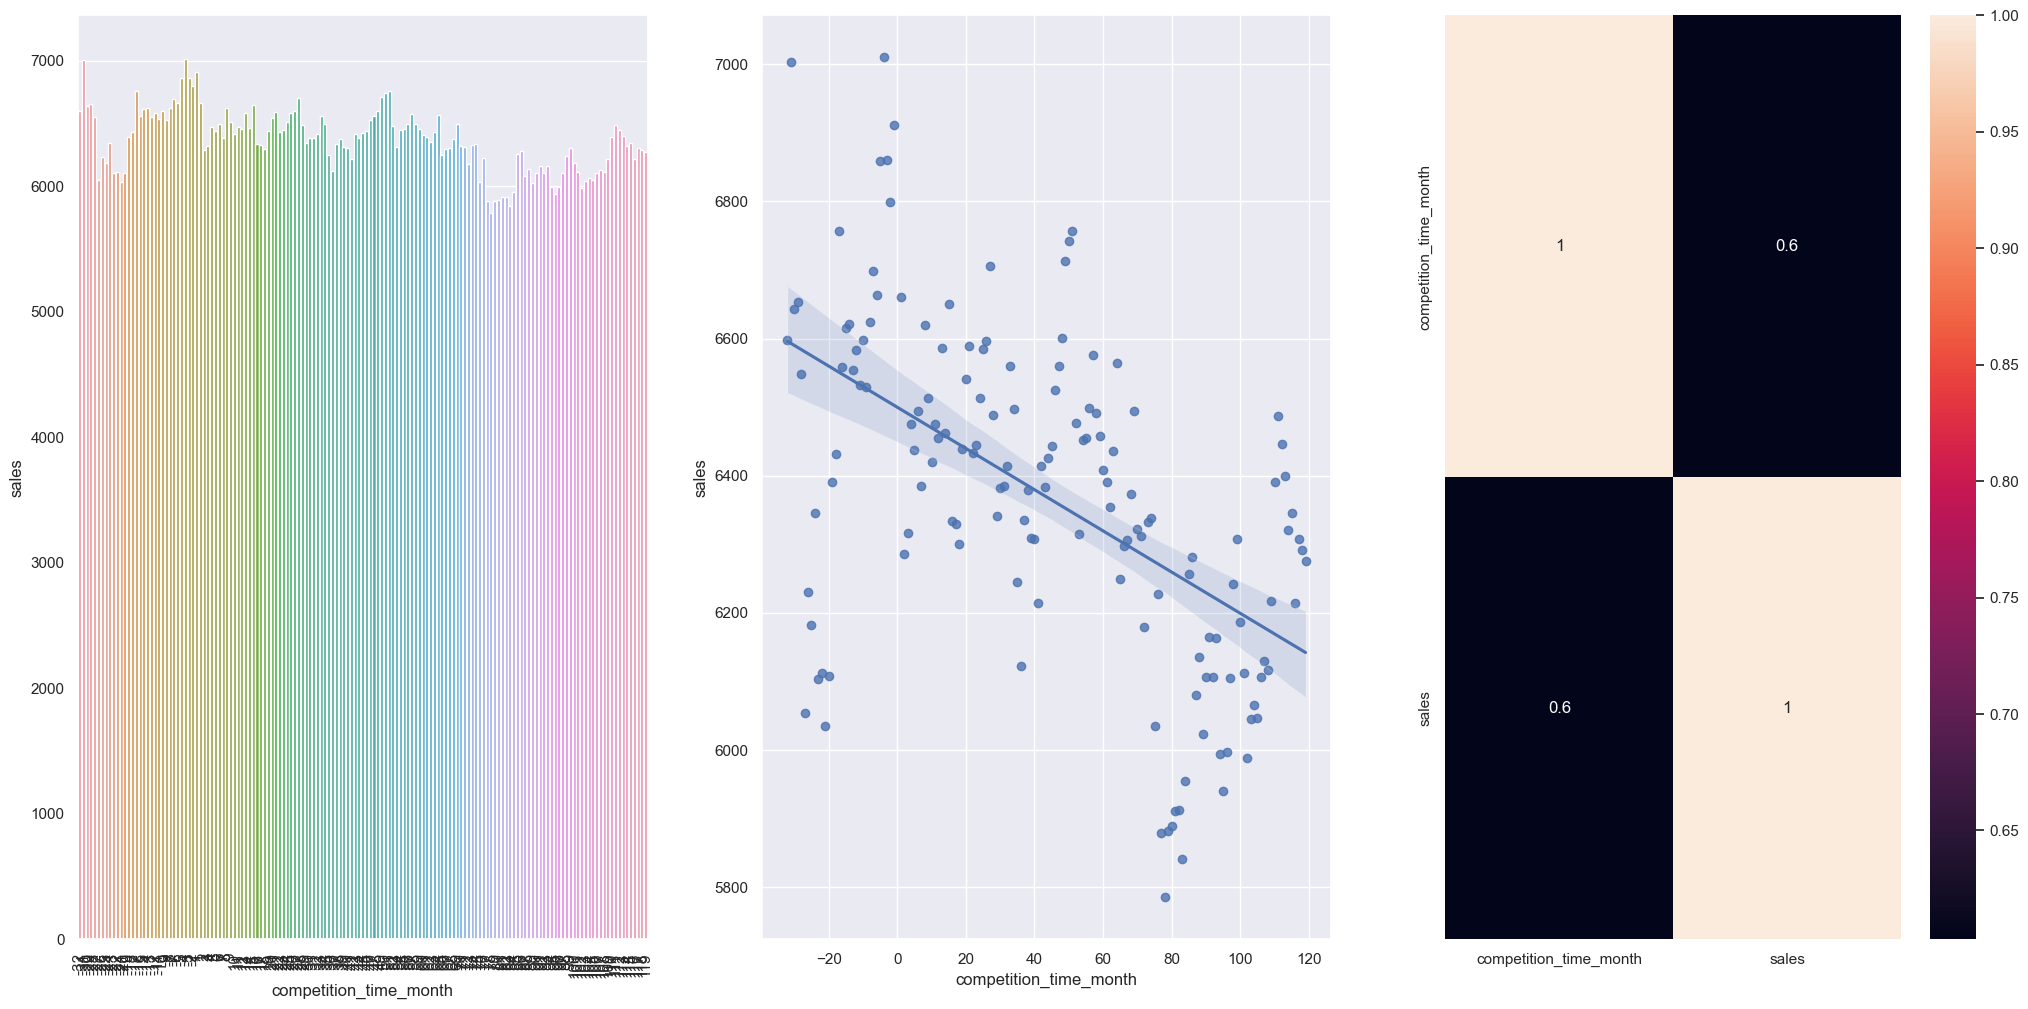

In [68]:
plt.subplot (1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').median().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot (x = 'competition_time_month', y = 'sales', data = aux2);
plt.xticks (rotation = 90);

plt.subplot (1, 3, 2)
sns.regplot (x = 'competition_time_month', y = 'sales', data = aux2);

plt.subplot (1, 3, 3)
sns.heatmap (aux1.corr (method = 'pearson'), annot = True);

#### H4. Lojas com promoções ativas durante mais tempo deveriam vender mais.
**VERDADEIRO**

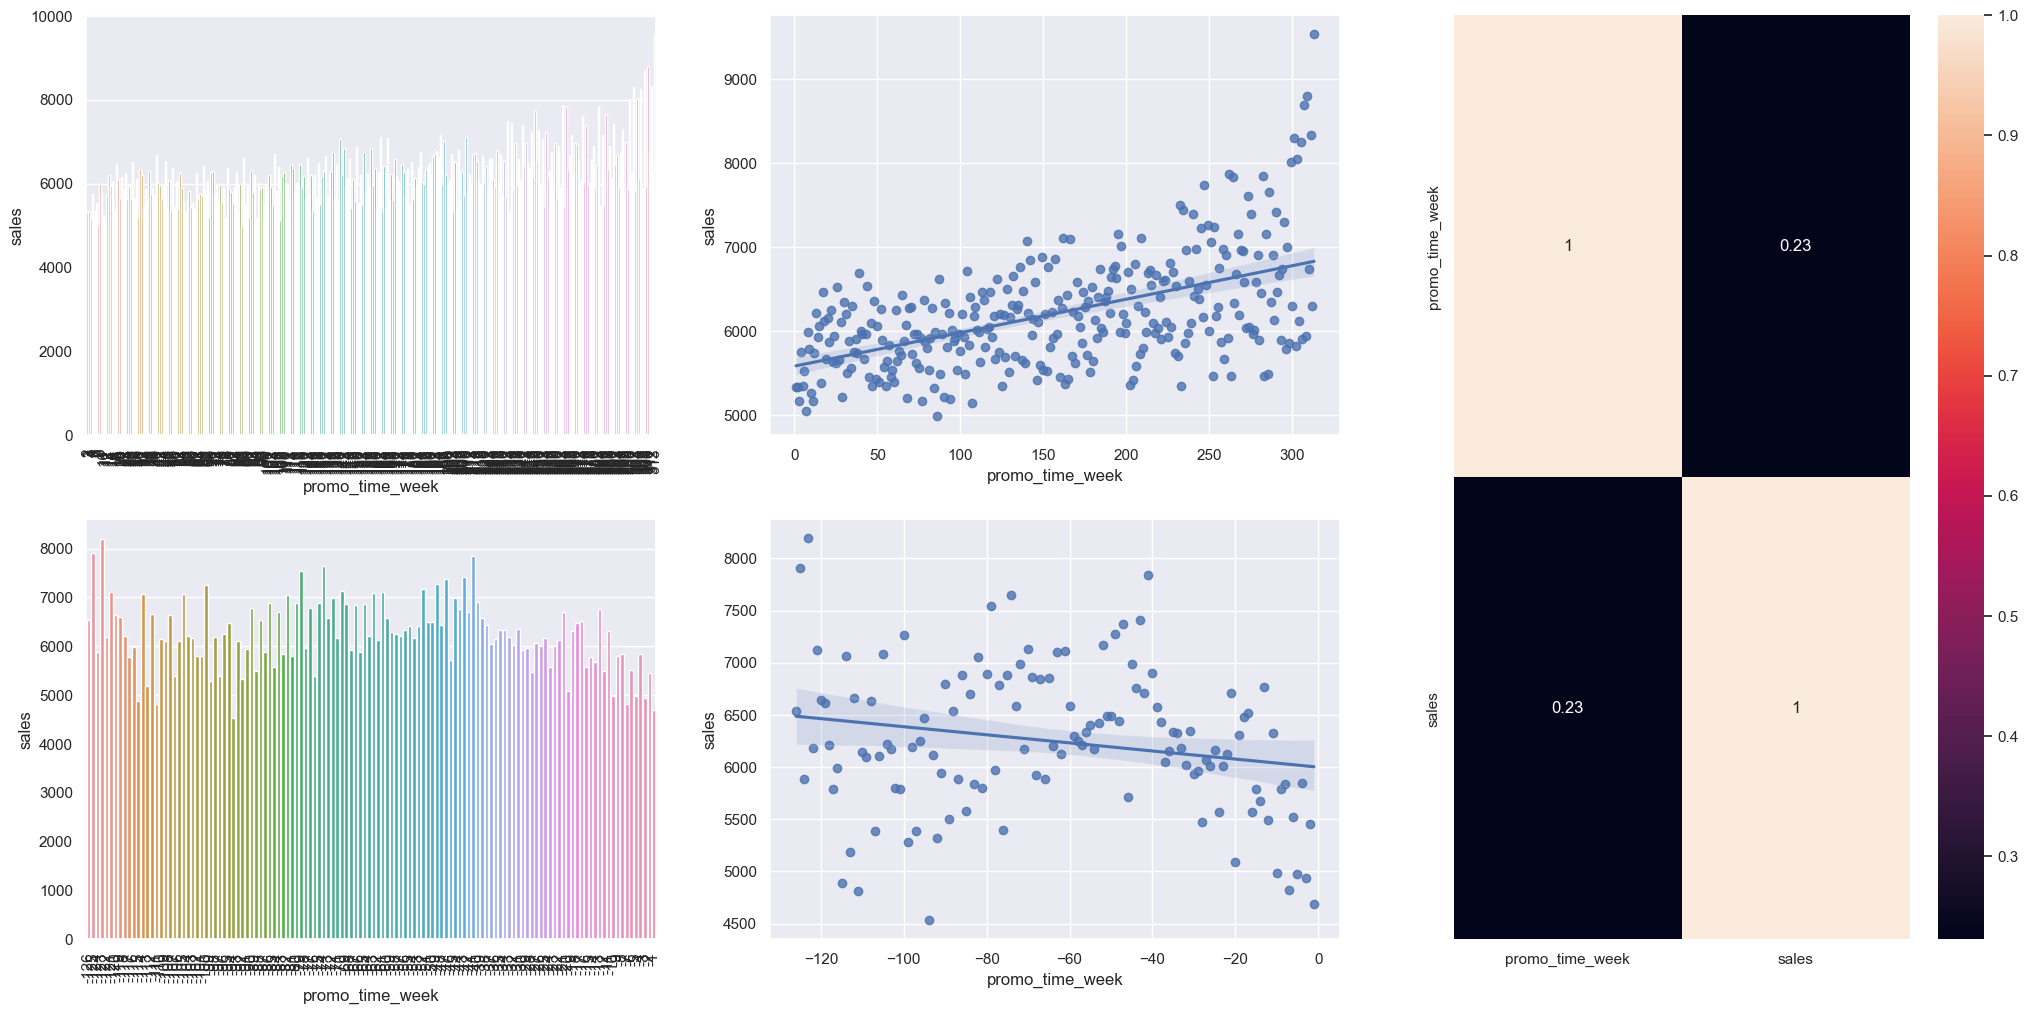

In [69]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').median().reset_index()

grid = GridSpec (2, 3)

plt.subplot (grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot (x = 'promo_time_week', y = 'sales', data = aux2);
plt.xticks (rotation = 90);

plt.subplot (grid[0, 1])
sns.regplot (x = 'promo_time_week', y = 'sales', data = aux2);

plt.subplot (grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot (x = 'promo_time_week', y = 'sales', data = aux3);
plt.xticks (rotation = 90);

plt.subplot (grid[1, 1])
sns.regplot (x = 'promo_time_week', y = 'sales', data = aux3);

plt.subplot (grid[:,2])
sns.heatmap (aux1.corr (method = 'pearson'), annot = True);

#### H5. Lojas com mais promoções consecutivas deveriam vender mais.
**FALSO** - Lojas com promo extendida vendem menos.

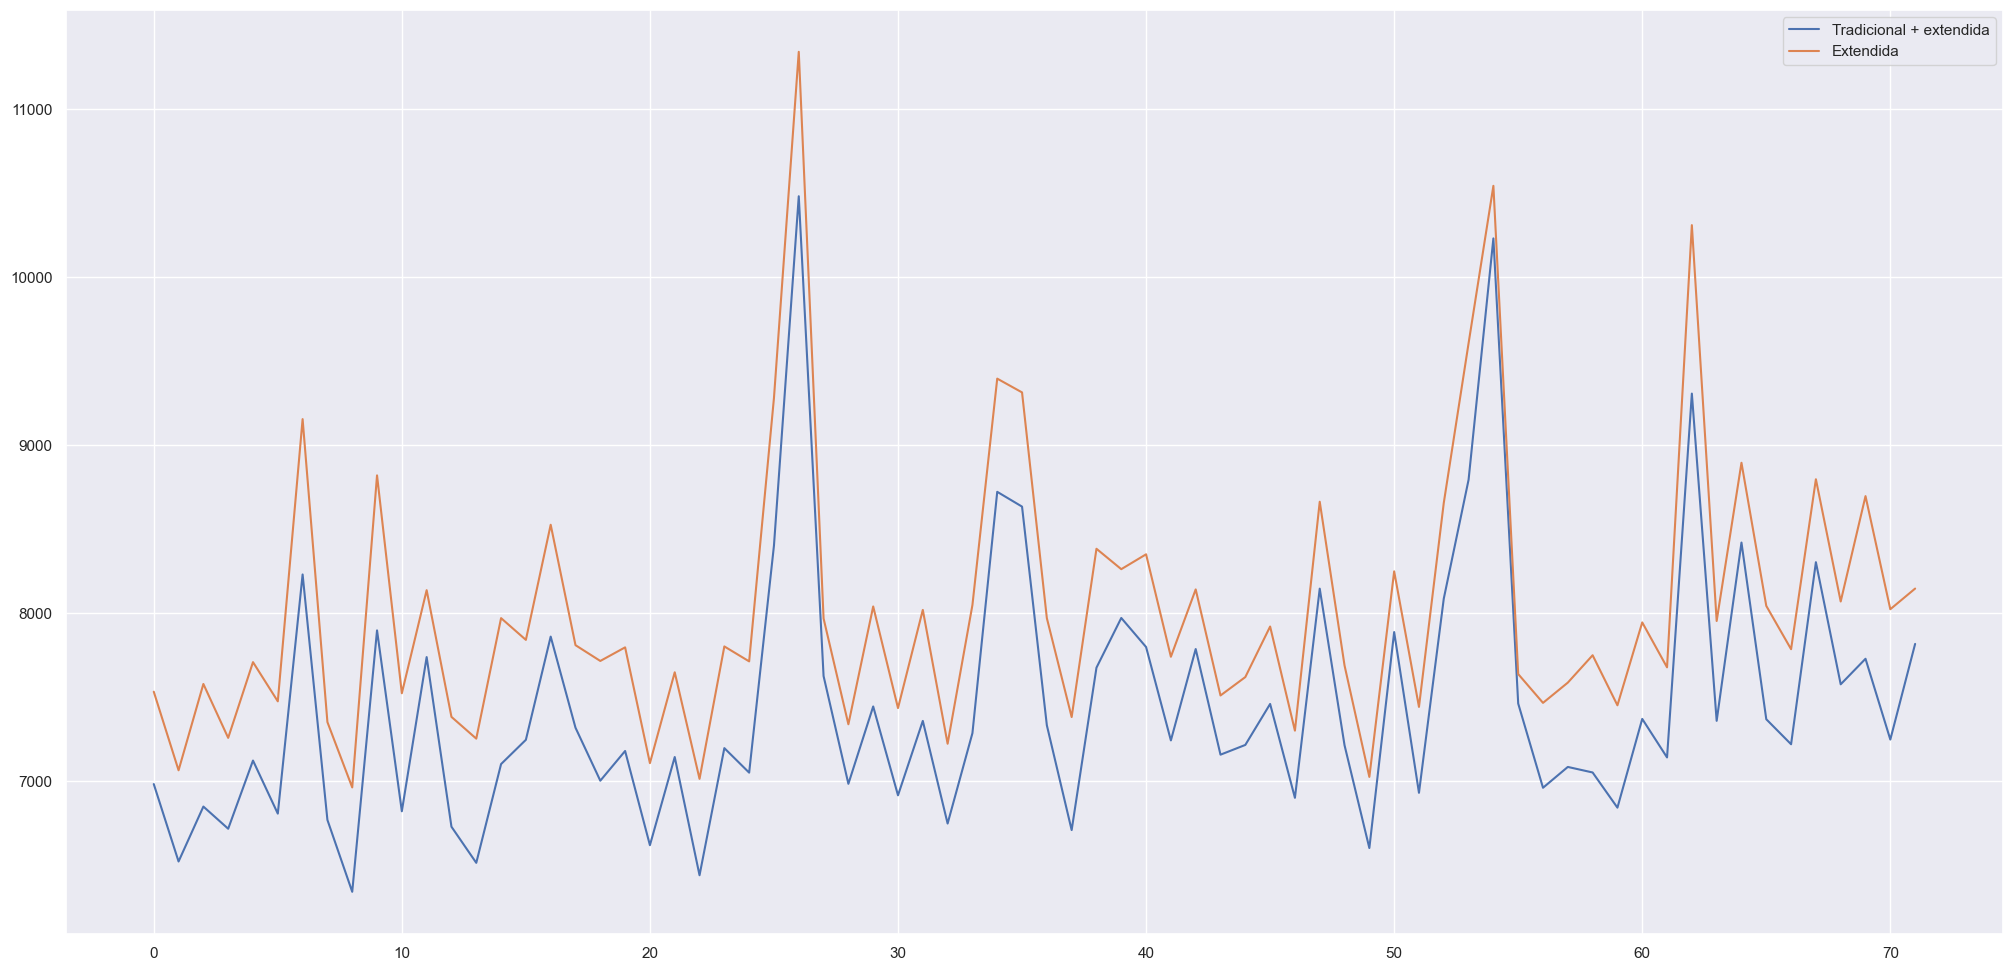

In [70]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').median().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').median().reset_index()
aux2.plot (ax = ax)

ax.legend (labels = ['Tradicional + extendida', 'Extendida'])

#### H6. Lojas abertas durante o Natal deveriam vender mais.
**VERDADEIRO**

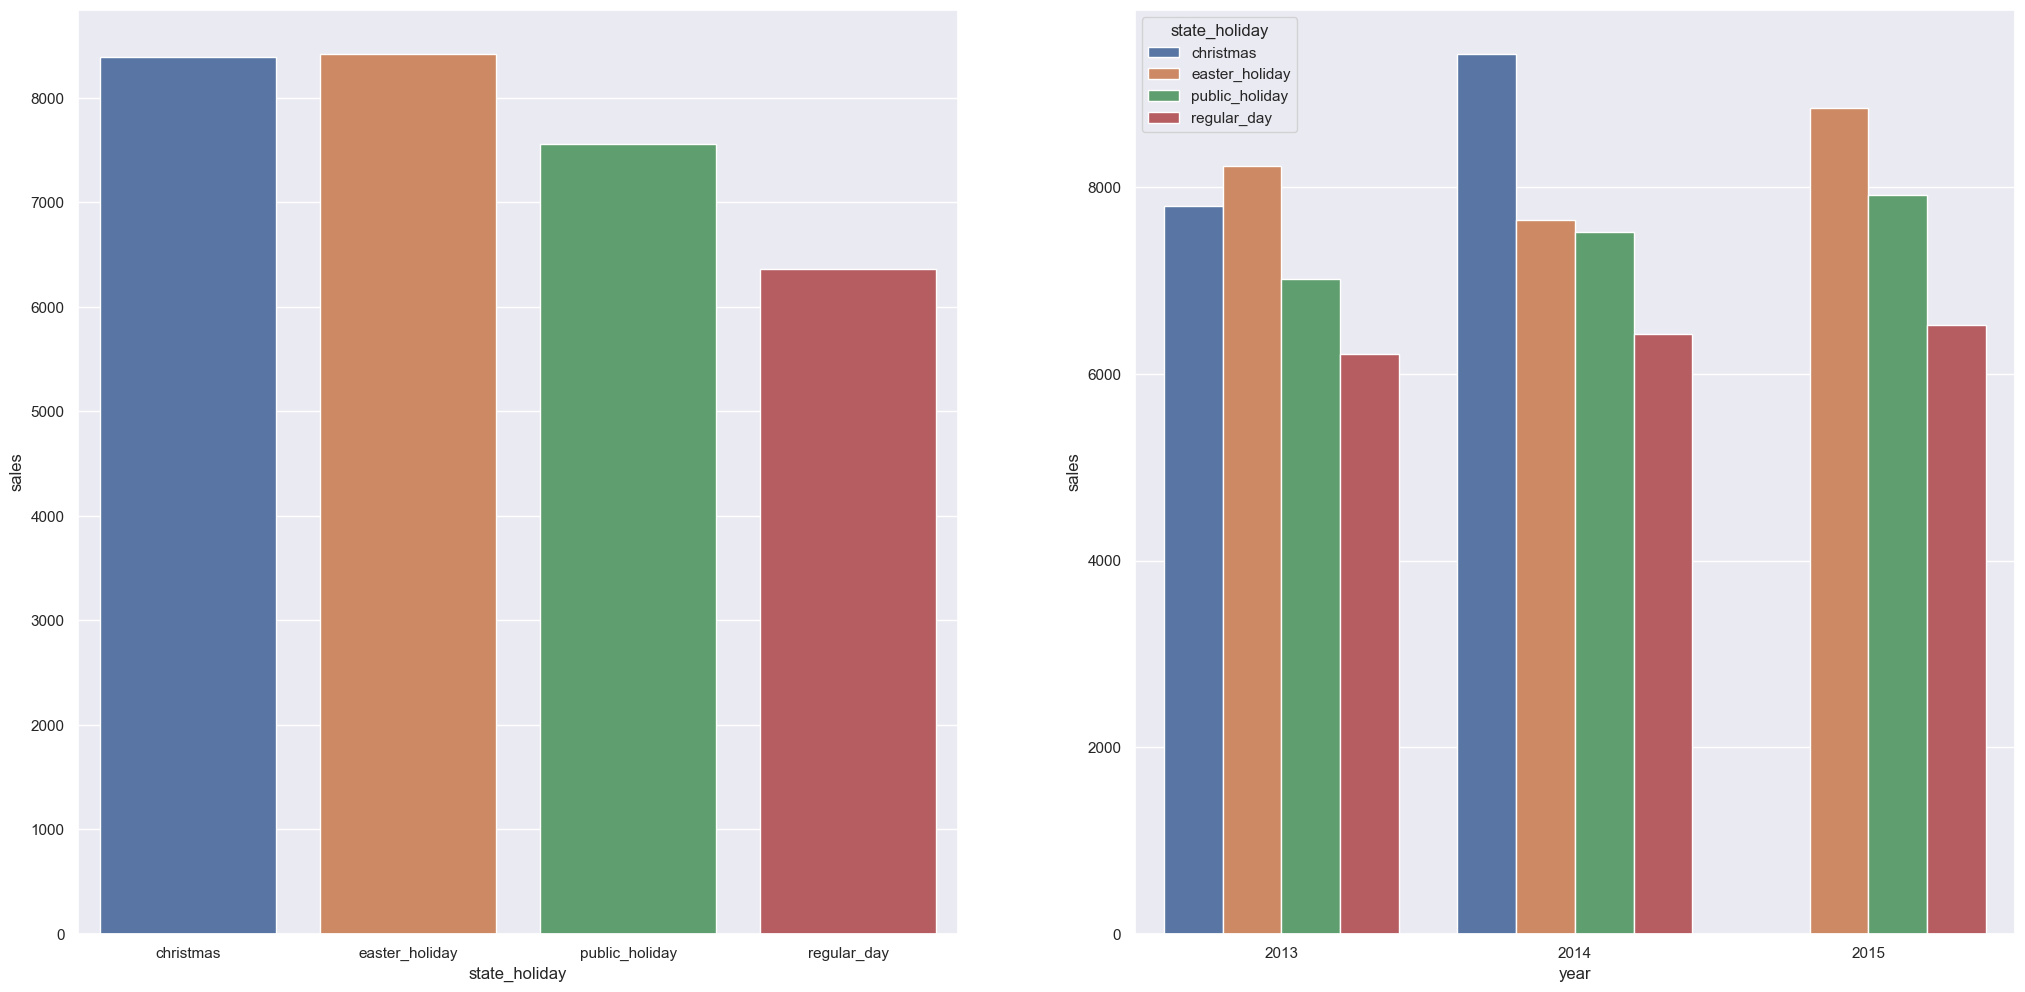

In [71]:
plt.subplot (1, 2, 1)
aux1 = df4[['state_holiday', 'sales']].groupby('state_holiday').median().reset_index()
sns.barplot (x = 'state_holiday', y = 'sales', data = aux1);

plt.subplot (1, 2, 2)
aux2 = df4[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).median().reset_index()
sns.barplot (x = 'year', y = 'sales', hue = 'state_holiday', data = aux2);

#### H7. Lojas deveriam vender mais ao longo dos anos.
**VERDADEIRO**

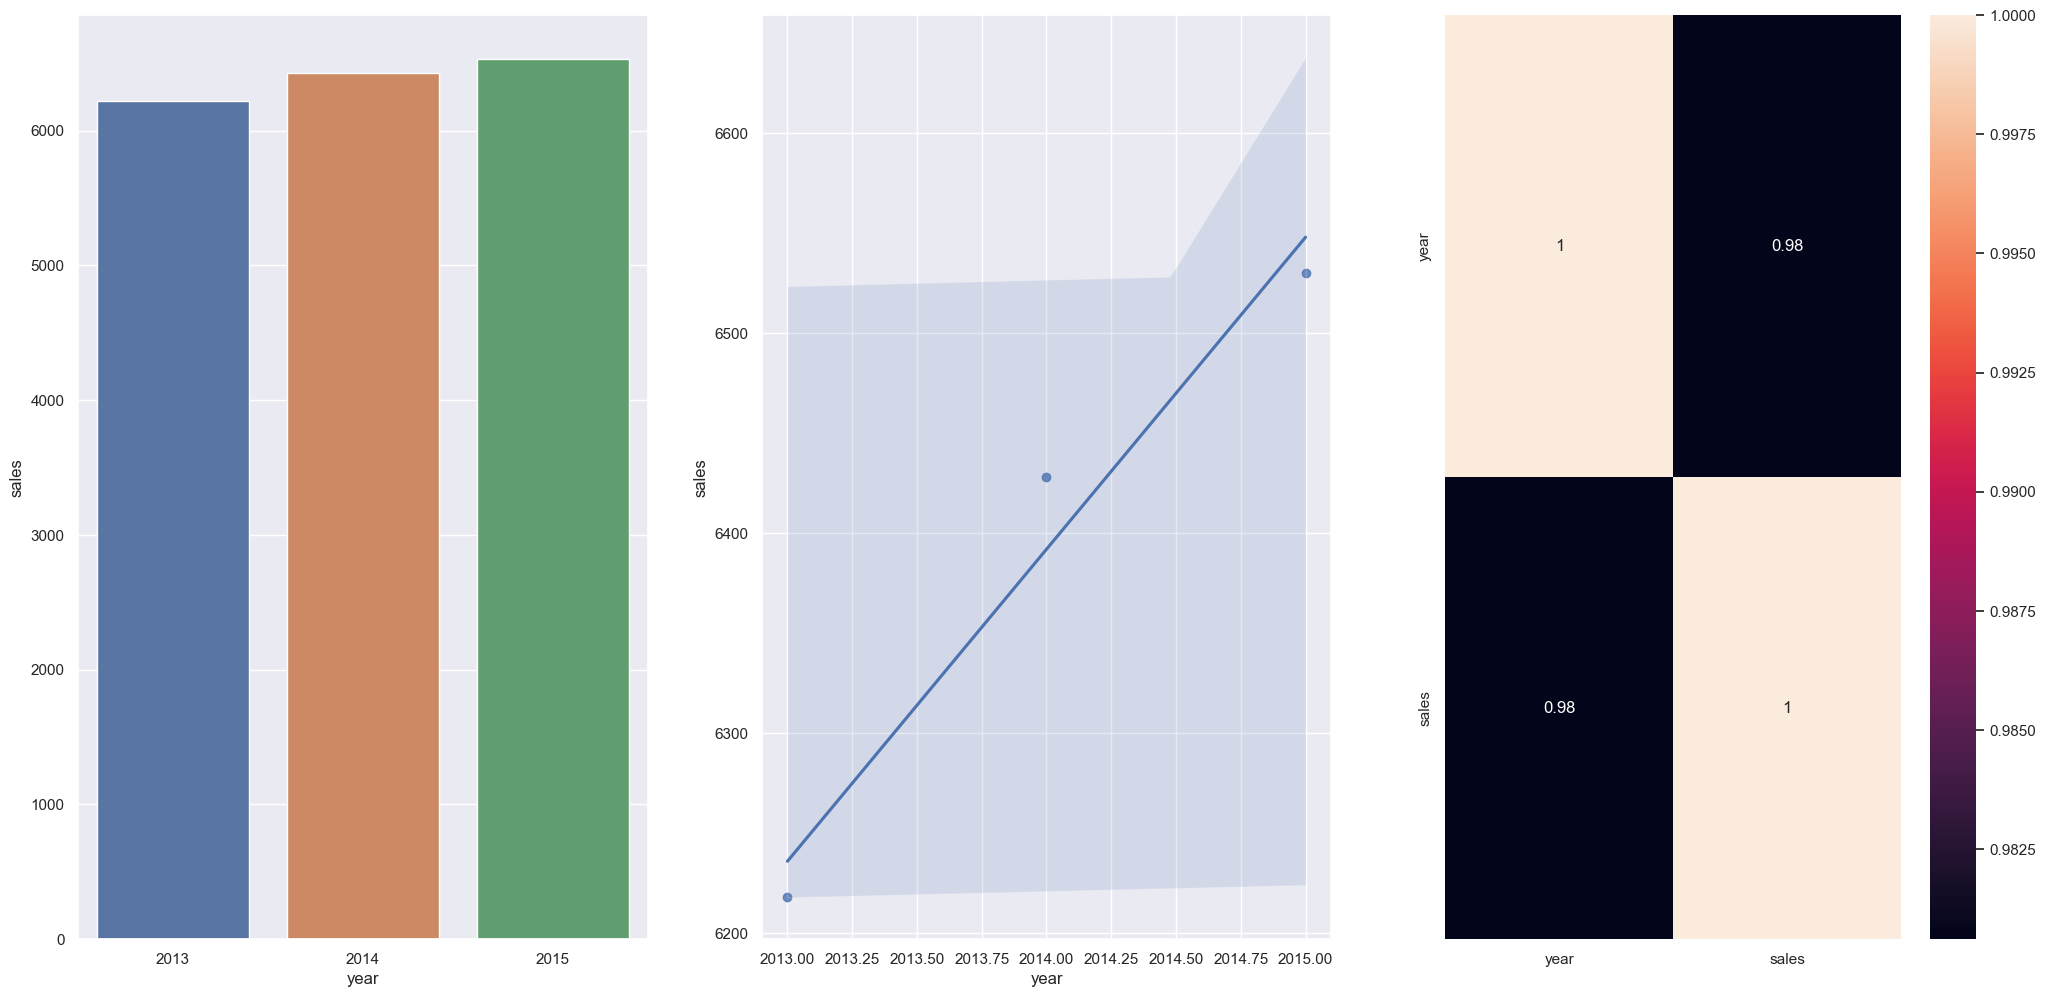

In [72]:
aux1 = df4[['year', 'sales']].groupby('year').median().reset_index()
plt.subplot (1, 3, 1)
sns.barplot (x = 'year', y = 'sales', data = aux1);

plt.subplot (1, 3, 2)
sns.regplot (x = 'year', y = 'sales', data = aux1);

plt.subplot (1, 3, 3)
sns.heatmap (aux1.corr (method = 'pearson'), annot = True);

#### H8. Lojas deveriam vender mais no segundo semestre do ano.
**VERDADEIRO**

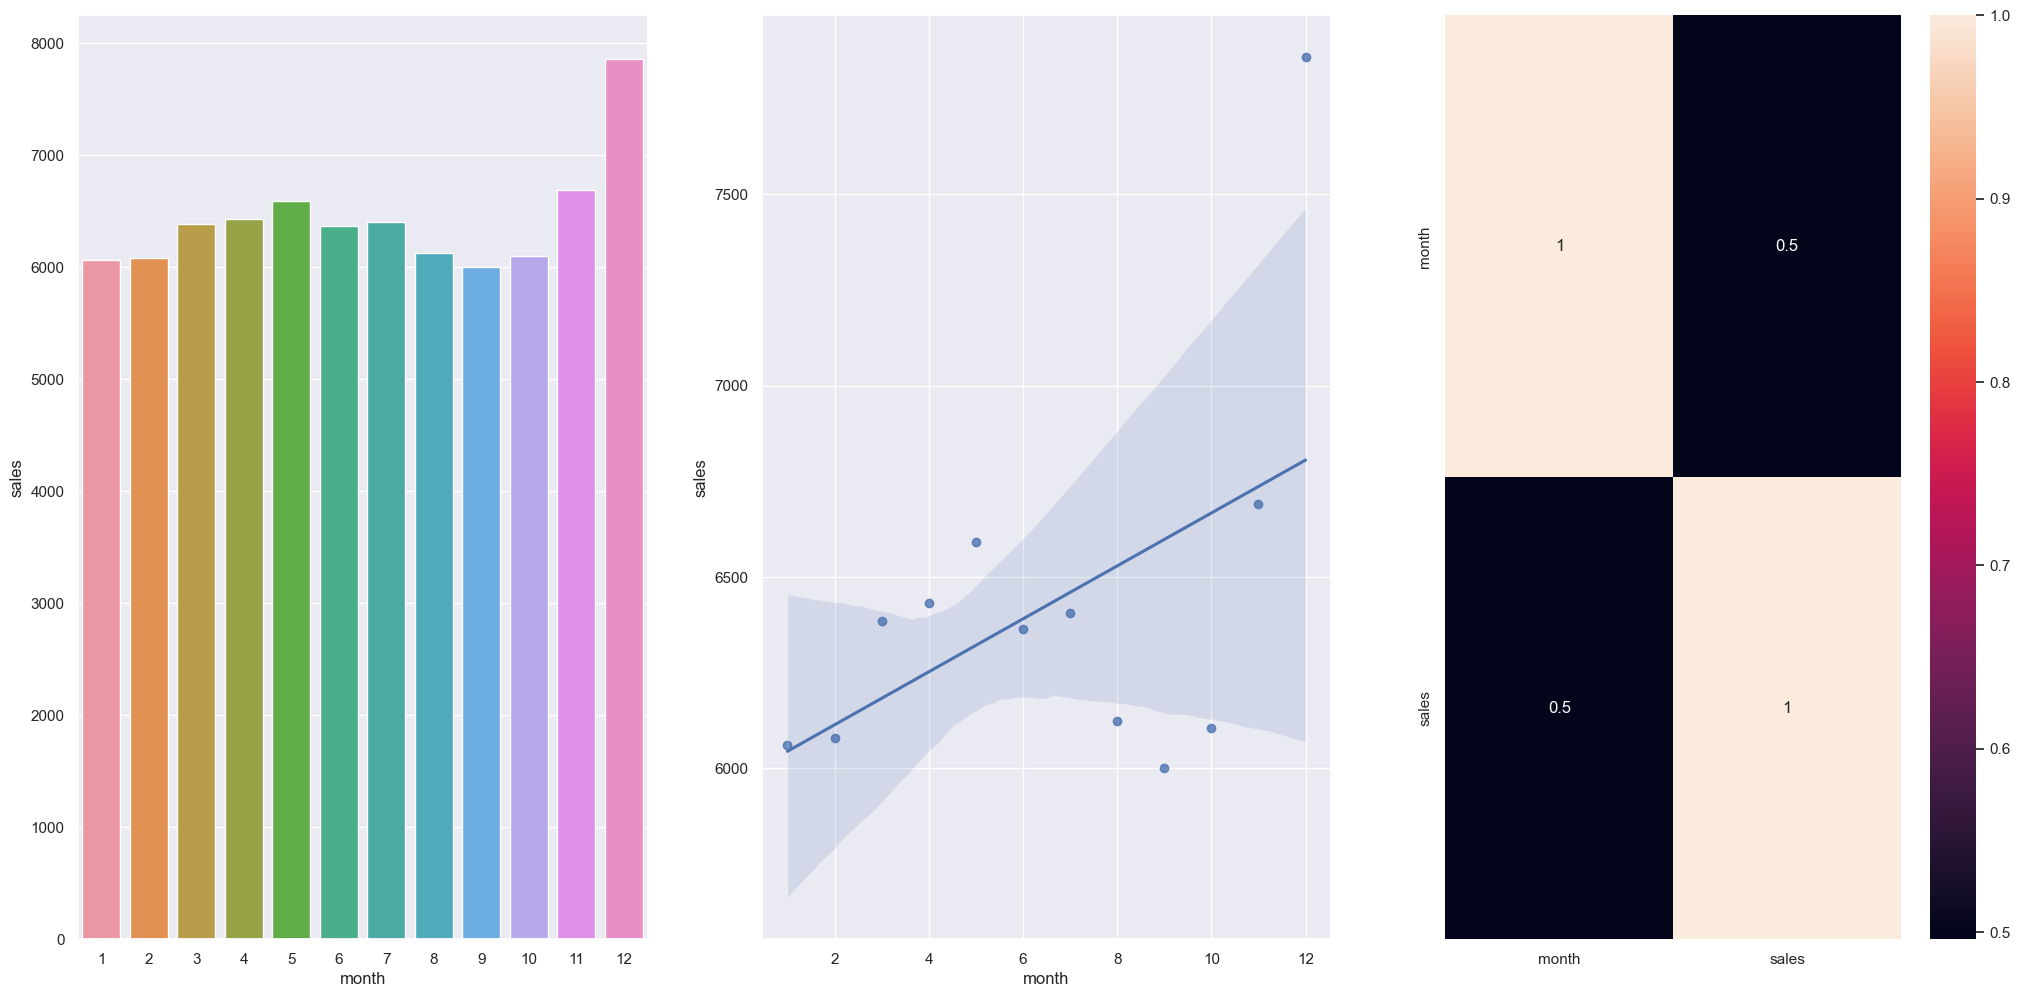

In [73]:
aux1 = df4[['month', 'sales']].groupby('month').median().reset_index()
plt.subplot (1, 3, 1)
sns.barplot (x = 'month', y = 'sales', data = aux1);

plt.subplot (1, 3, 2)
sns.regplot (x = 'month', y = 'sales', data = aux1);

plt.subplot (1, 3, 3)
sns.heatmap (aux1.corr (method = 'pearson'), annot = True);

#### H9. Lojas deveriam vender mais depois do dia 10 de cada mês.
**FALSO** - Vendem menos.

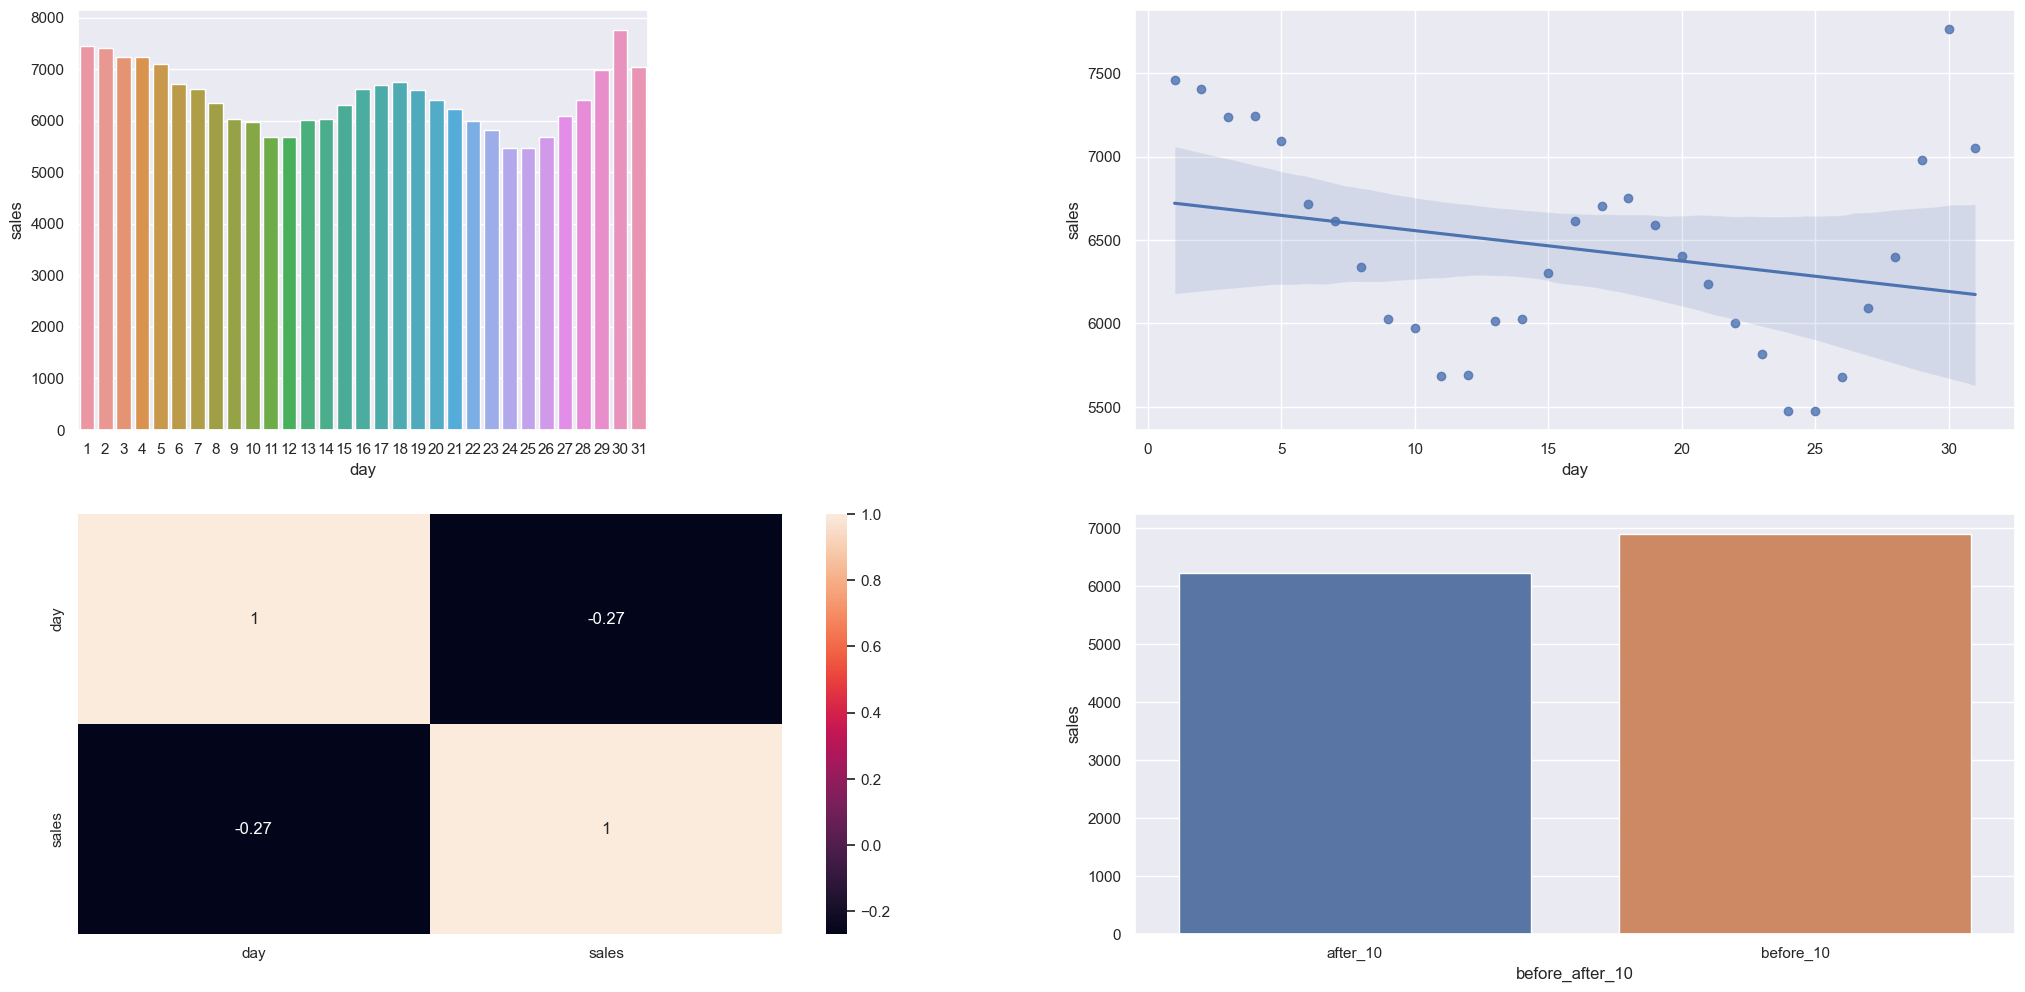

In [74]:
aux1 = df4[['day', 'sales']].groupby('day').median().reset_index()
plt.subplot (2, 3, 1)
sns.barplot (x = 'day', y = 'sales', data = aux1);

plt.subplot (2, 2, 2)
sns.regplot (x = 'day', y = 'sales', data = aux1);

plt.subplot (2, 2, 3)
sns.heatmap (aux1.corr (method = 'pearson'), annot = True);

plt.subplot (2, 2, 4)
aux1['before_after_10'] = aux1['day'].apply (lambda x: 'before_10' if x <= 10 else 'after_10')
aux2  = aux1[['before_after_10', 'sales']].groupby('before_after_10').median().reset_index()
sns.barplot (x = 'before_after_10', y = 'sales', data = aux2);

#### H10. Lojas deveriam vender mais nos fins de semana.
**FALSO** - Vendem menos.

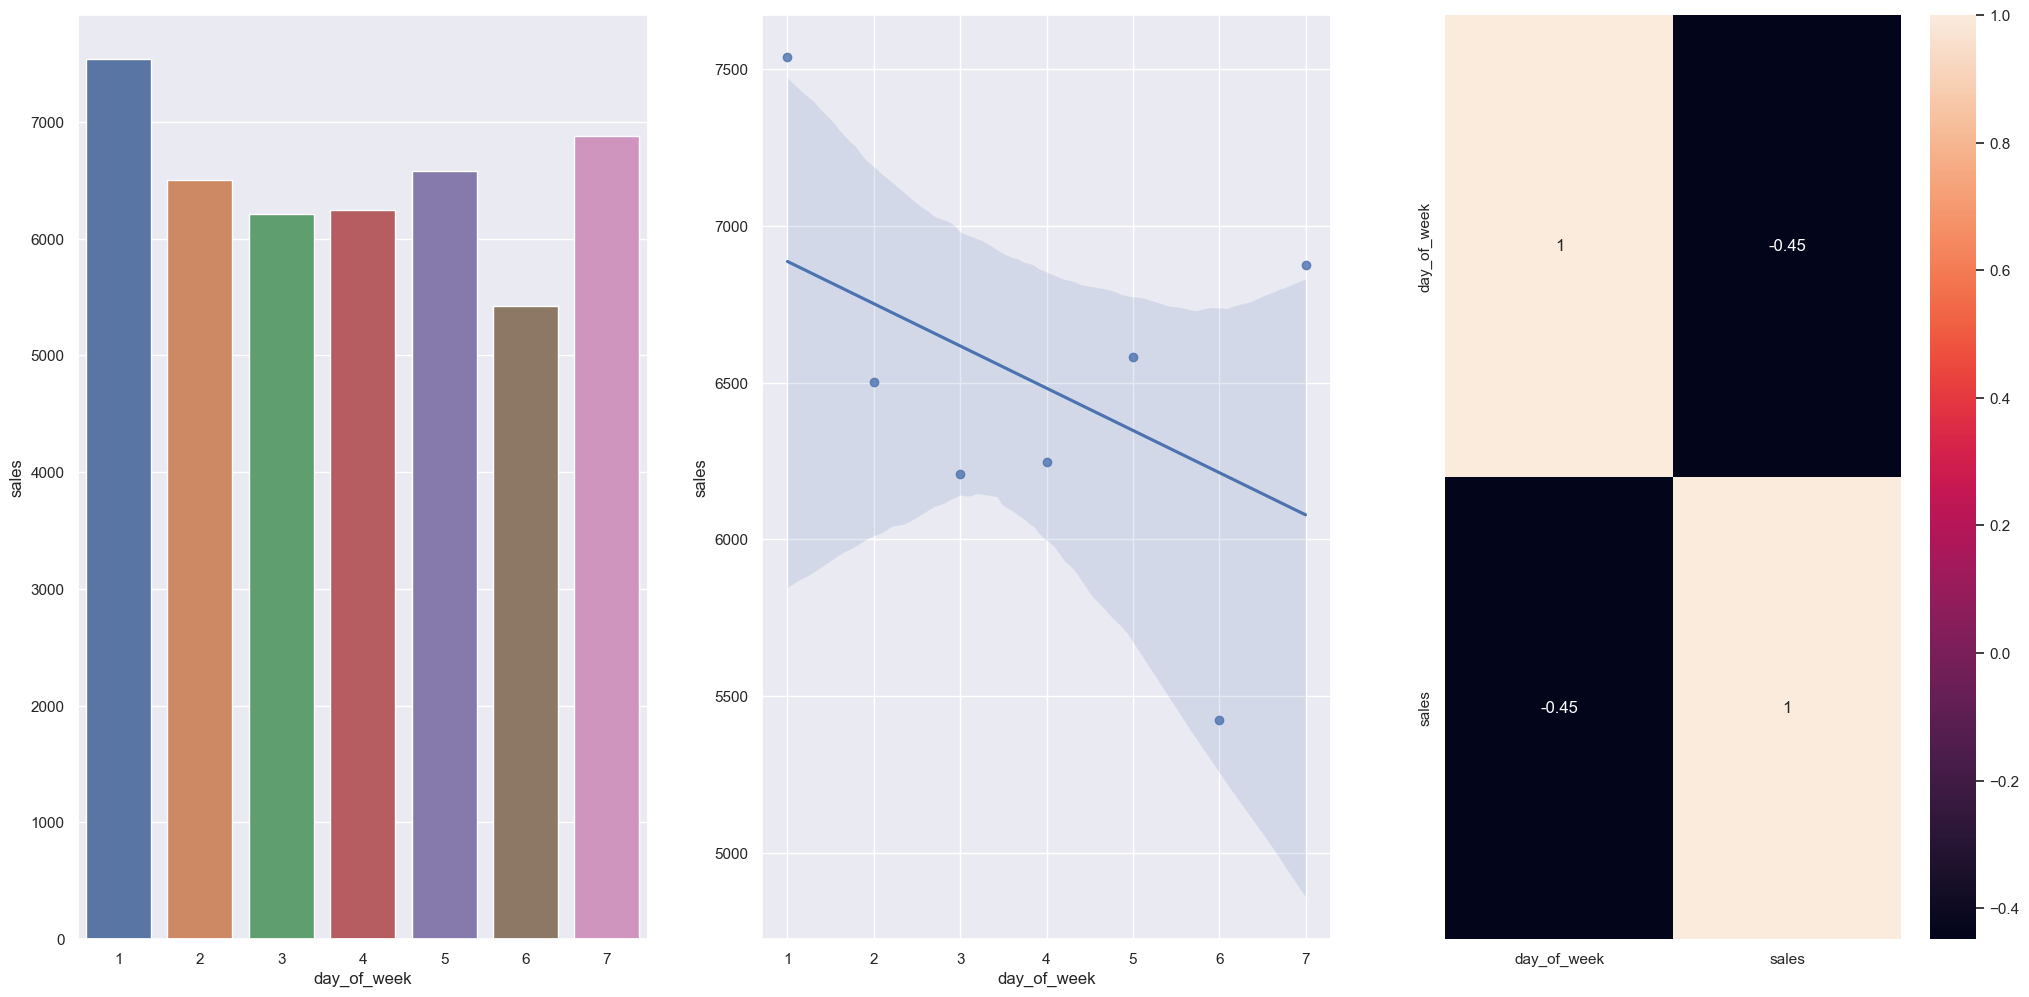

In [75]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').median().reset_index()
plt.subplot (1, 3, 1)
sns.barplot (x = 'day_of_week', y = 'sales', data = aux1);

plt.subplot (1, 3, 2)
sns.regplot (x = 'day_of_week', y = 'sales', data = aux1);

plt.subplot (1, 3, 3)
sns.heatmap (aux1.corr (method = 'pearson'), annot = True);

#### H11. Lojas deveriam vender menos durante férias escolares.
**FALSO** - Vendem mais.

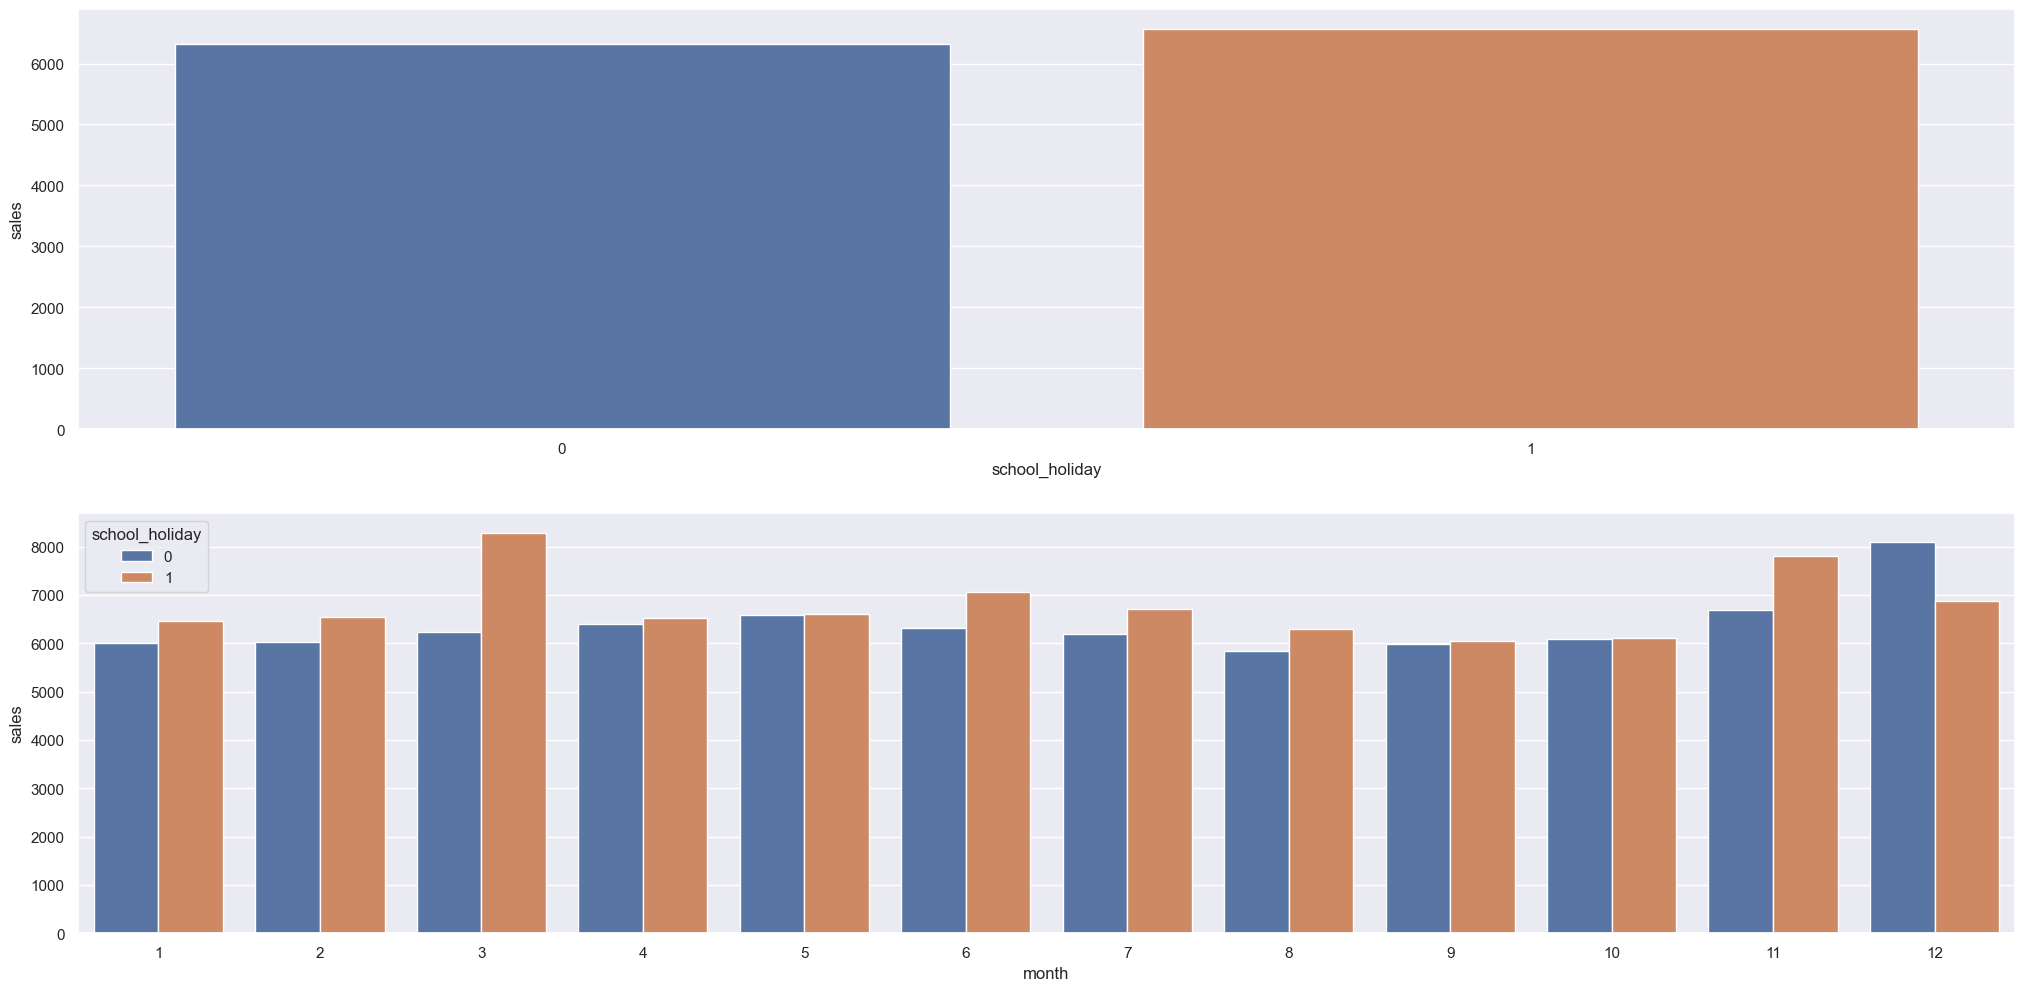

In [76]:
plt.subplot (2, 1, 1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').median().reset_index()
sns.barplot (x = 'school_holiday', y = 'sales', data = aux1);

plt.subplot (2, 1, 2)
aux2 = df4[['school_holiday', 'month', 'sales']].groupby(['school_holiday', 'month']).median().reset_index()
sns.barplot (x = 'month', y = 'sales', hue = 'school_holiday', data = aux2);

#### 4.2.1. Resumo hipóteses

In [77]:
tab = [['Hipótese', 'Conclusão', 'Relevância'], 
       ['H1', 'Verdadeira', 'Alta'],
       ['H2', 'Falso', 'Baixa'],
       ['H3', 'Verdadeira', 'Alta'],
       ['H4', 'Verdadeira', 'Média'],
       ['H5', 'Falso', 'Baixa'],
       ['H6', 'Verdadeira', 'Média'],
       ['H7', 'Verdadeira', 'Alta'],
       ['H8', 'Verdadeira', 'Média'],
       ['H9', 'Falso', 'Média'],
       ['H10', 'Falso', 'Médio'],
       ['H11', 'Falso', 'Baixo']]
print (tabulate(tab, headers = 'firstrow'))

Hipótese    Conclusão    Relevância
----------  -----------  ------------
H1          Verdadeira   Alta
H2          Falso        Baixa
H3          Verdadeira   Alta
H4          Verdadeira   Média
H5          Falso        Baixa
H6          Verdadeira   Média
H7          Verdadeira   Alta
H8          Verdadeira   Média
H9          Falso        Média
H10         Falso        Médio
H11         Falso        Baixo


### 4.3. Análise multivariada
1. Lojas com maior sortimento deveriam vender mais.

2. Lojas com competidores próximos deveriam vender menos.

3. Lojas com competidores a mais tempo deveriam vender menos.

#### 4.3.1. Numerical attributes

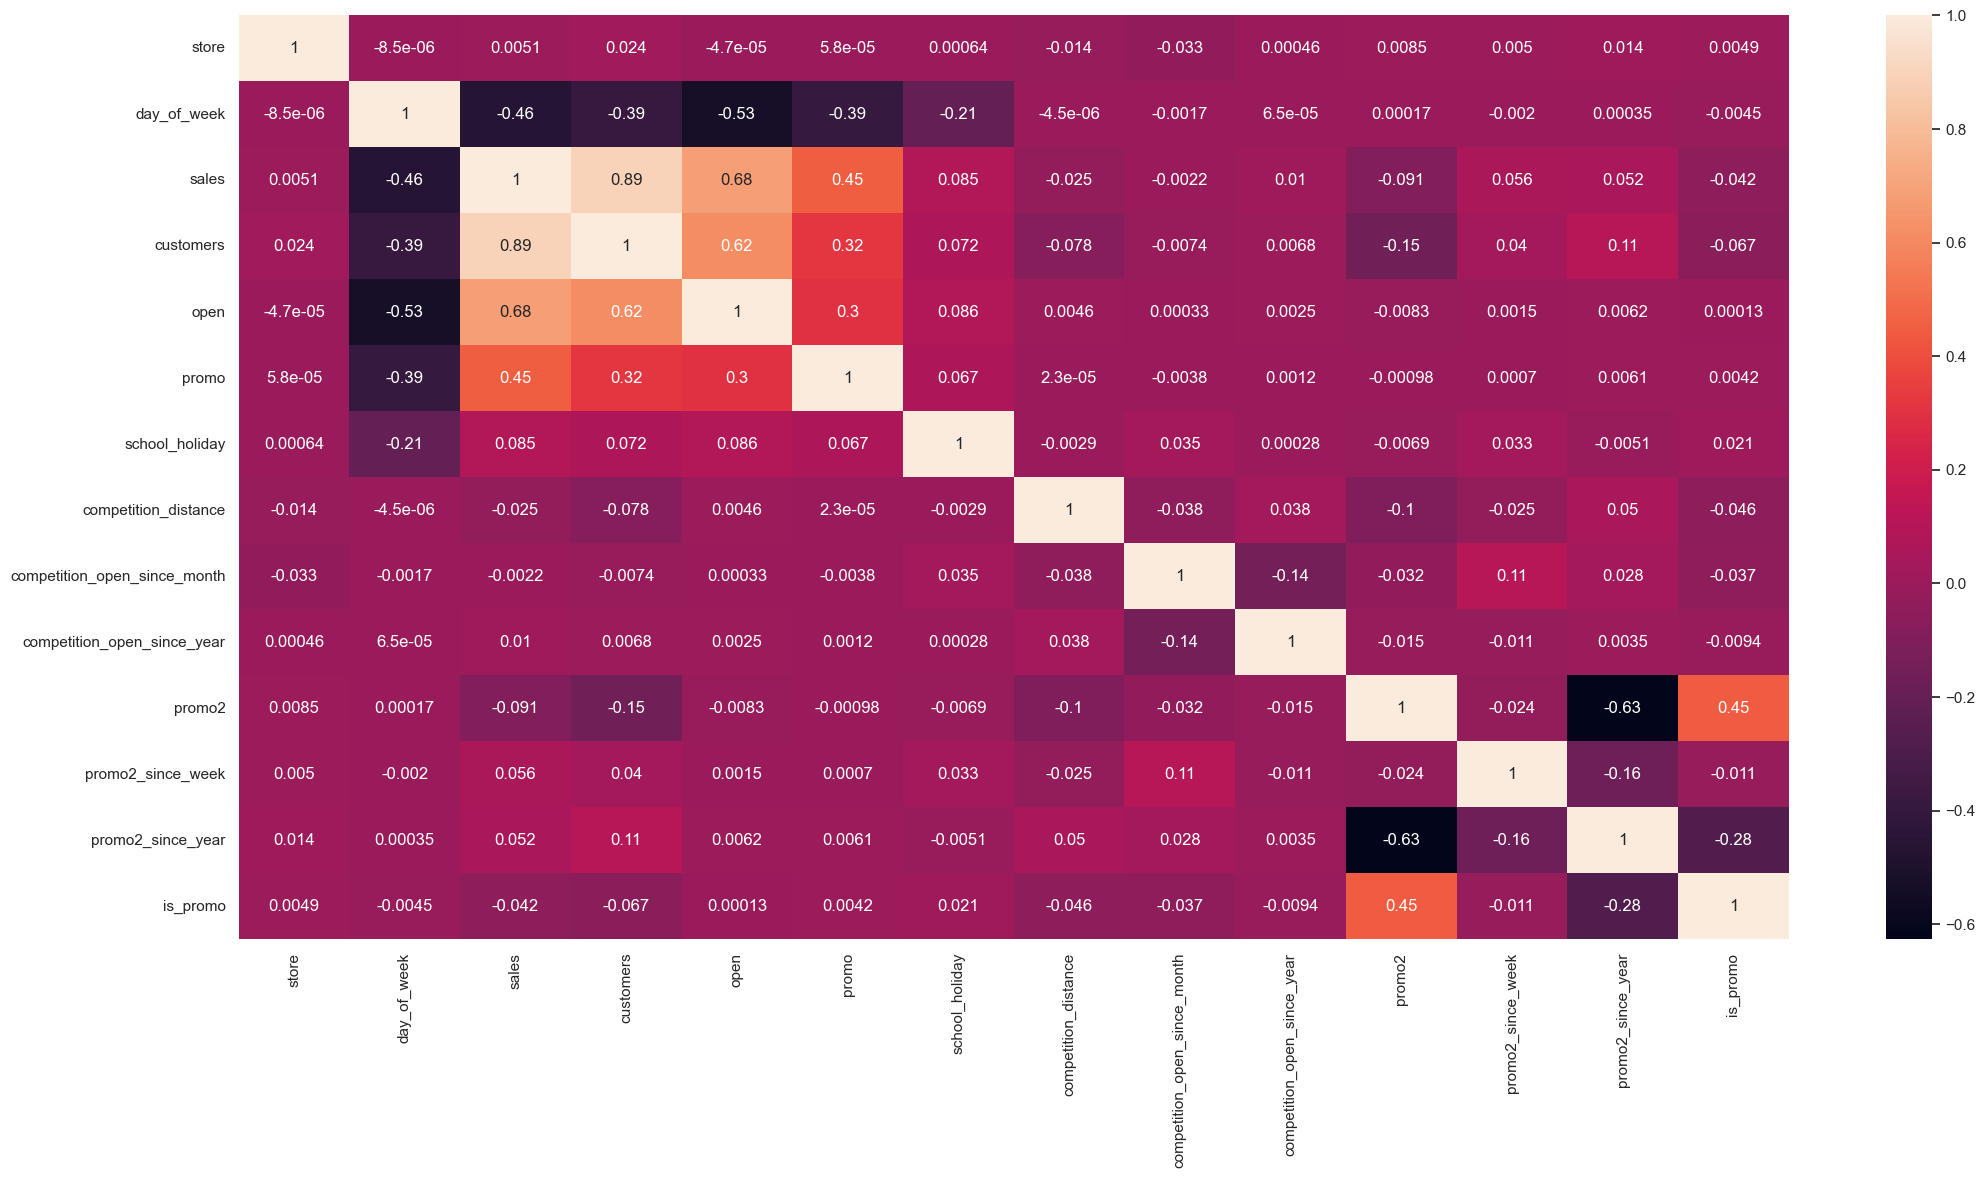

In [78]:
correlation = num_attributes.corr (method = 'pearson')
sns.heatmap (correlation, annot = True);

#### 4.3.2. Categorical attributes

In [79]:
a = df4.select_dtypes (include = 'object')
a1 = cramers_v (a['state_holiday'], a['state_holiday'])
a2 = cramers_v (a['state_holiday'], a['store_type'])
a3 = cramers_v (a['state_holiday'], a['assortment'])

a4 = cramers_v (a['store_type'], a['state_holiday'])
a5 = cramers_v (a['store_type'], a['store_type'])
a6 = cramers_v (a['store_type'], a['assortment'])

a7 = cramers_v (a['assortment'], a['state_holiday'])
a8 = cramers_v (a['assortment'], a['store_type'])
a9 = cramers_v (a['assortment'], a['assortment'])

d = pd.DataFrame ({'state_holiday': [a1, a2, a3], 'store_type': [a4, a5, a6], 'assortment': [a7, a8, a9]})
d = d.set_index (d.columns)
d

,state_holiday,store_type,assortment
state_holiday,1.000000,0.071040,0.067519
store_type,0.071040,1.000000,0.538454
assortment,0.067519,0.538454,1.000000


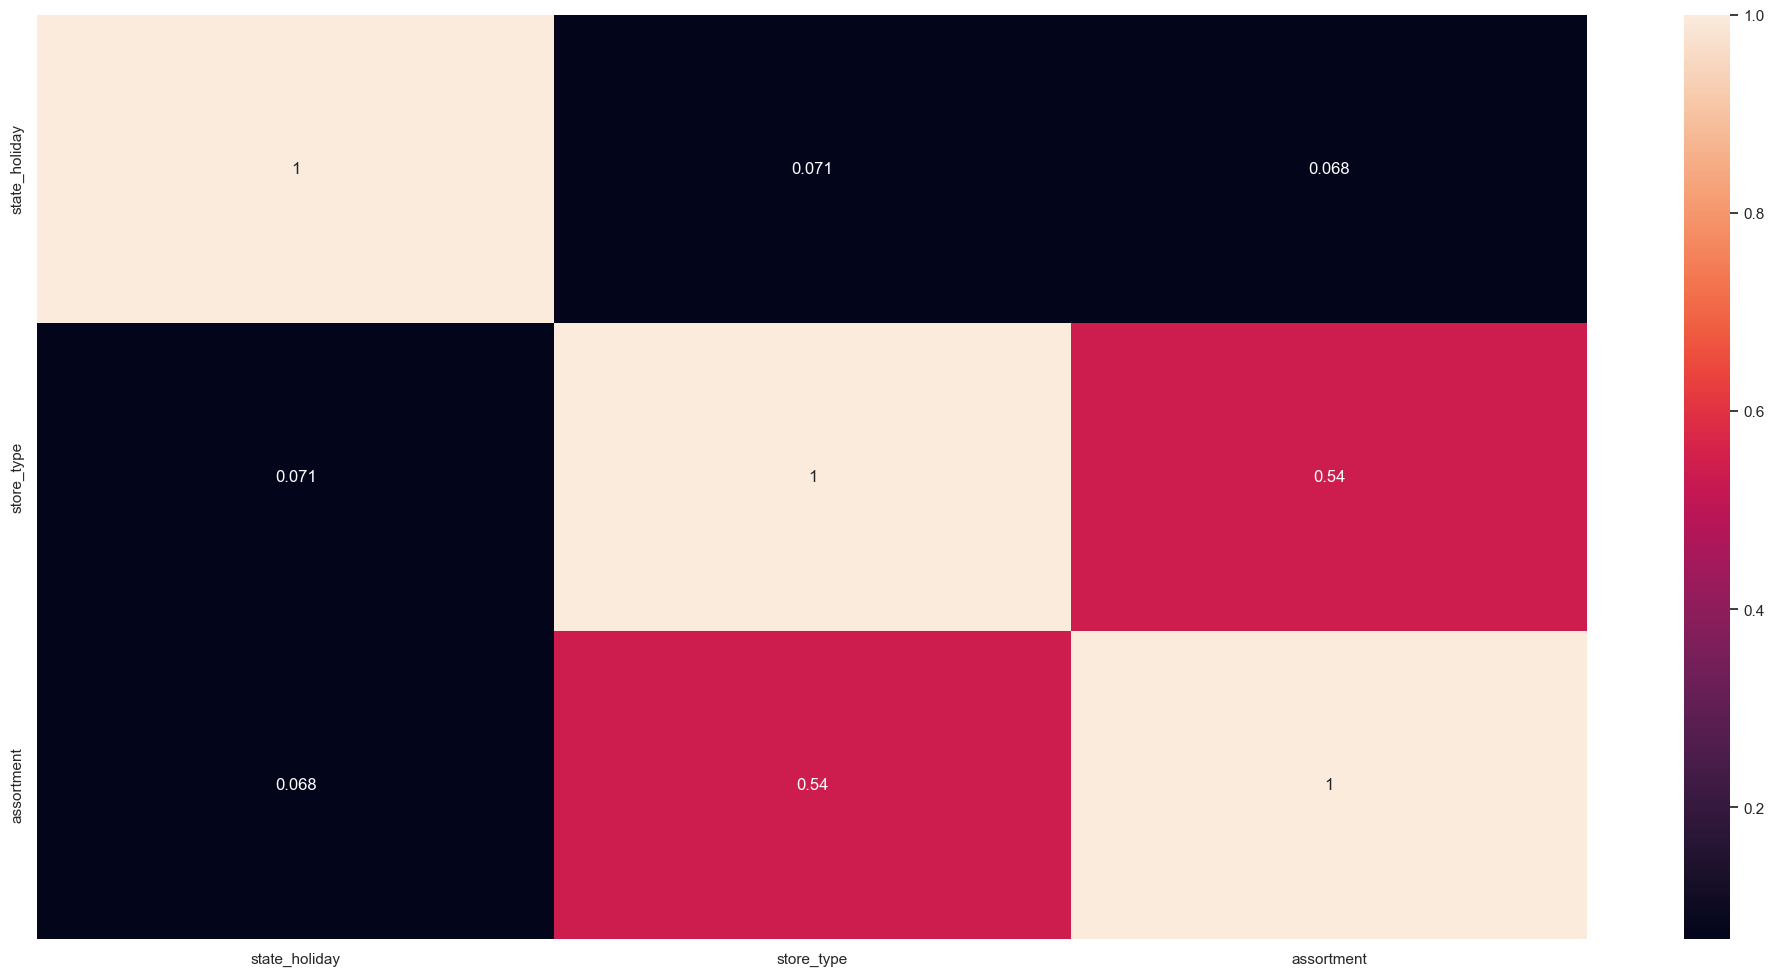

In [80]:
sns.heatmap (d, annot = True);

## 5.0. PASSO 05 - Data preparation

In [81]:
df5 = df4.copy()

### 5.1. Normalização

### 5.2. Rescaling

In [82]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform (df5[['competition_distance']].values)
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

# competition_time_month
df5['competition_time_month'] = rs.fit_transform (df5[['competition_time_month']].values)
pickle.dump(rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb'))

# promo_time_week
df5['promo_time_week'] = mms.fit_transform (df5[['promo_time_week']].values)
pickle.dump(mms, open('parameter/promo_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform (df5[['year']].values)
pickle.dump(mms, open('parameter/year_scaler.pkl', 'wb'))

### 5.3. Transformação

#### 5.3.1. Encoding

In [83]:
# state_holiday - One hot encoding
df5 = pd.get_dummies (df5, prefix = ['state_holiday'], columns = ['state_holiday'])

In [84]:
# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform (df5['store_type'])
pickle.dump(le, open('parameter/store_type_scaler.pkl', 'wb'))

In [85]:
# assortment - Ordinal Encoding
assortment_dict = {'basic': 0, 'extra': 1, 'extended': 2}
df5['assortment'] = df5['assortment'].map (assortment_dict)

#### 5.3.2. Response variable transformation

In [86]:
df5['sales'] = np.log1p (df5['sales'])

#### 5.3.3. Nature transformation

In [87]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply (lambda x: np.sin (x*2*np.pi/7))
df5['day_of_week_cos'] = df5['day_of_week'].apply (lambda x: np.cos (x*2*np.pi/7))

In [88]:
# month
df5['month_sin'] = df5['month'].apply (lambda x: np.sin (x*2*np.pi/12))
df5['month_cos'] = df5['month'].apply (lambda x: np.cos (x*2*np.pi/12))

In [89]:
# day
df5['day_sin'] = df5['day'].apply (lambda x: np.sin (x*2*np.pi/30))
df5['day_cos'] = df5['day'].apply (lambda x: np.cos (x*2*np.pi/30))

In [90]:
# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply (lambda x: np.sin (x*2*np.pi/52))
df5['week_of_year_cos'] = df5['week_of_year'].apply (lambda x: np.cos (x*2*np.pi/52))

## 6.0. PASSO 06 - Feature selection

In [91]:
df6 = df5.copy()

### 6.1. Split dataframe into training and test dataset

In [92]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop (cols_drop, axis = 1)

In [93]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta (days = 6*7)

Timestamp('2015-06-19 00:00:00')

In [94]:
# train dataset
x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']

# test dataset
x_test = df6[df6['date'] > '2015-06-18']
y_test = x_test['sales']

### 6.2. Boruta as feature selector

In [95]:
## train and test dataset for Boruta
#x_train_n = x_train.drop (['date', 'sales'], axis = 1).values
#y_train_n = y_train.values.ravel()
#
## define RandomForestRegressor
#rf = RandomForestRegressor (n_jobs = -1)
#
## define boruta
#boruta = BorutaPy (rf, n_estimators = 'auto', verbose = 2, random_state = 10).fit(x_train_n, y_train_n)

#### 6.2.1. Best Features from Boruta

In [96]:
#cols_selected = boruta.support_.tolist()
#
#x_train_fs = x_train.drop(['date', 'sales'], axis = 1)
#cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()
#
#cols_not_selected_boruta = list(np.setdiff1d (x_train_fs.columns, cols_selected_boruta))

### 6.3. Manual feature selection

In [97]:
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_cos',
                        'month_sin',
                        'day_sin',
                        'day_cos',
                        'week_of_year_cos',
                        'week_of_year_sin']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [98]:
cols_selected_boruta_full

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'week_of_year_sin',
 'date',
 'sales']

## 7.0. PASSO 07 - Machine learning modeling

In [99]:
X_train = x_train[cols_selected_boruta]
X_test = x_test[cols_selected_boruta]

# Time series data preparation
x_training = x_train[cols_selected_boruta_full]

### 7.1. Average model

In [100]:
aux1 = X_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns = {'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


### 7.2. Linear regression model

In [101]:
# model
lr = LinearRegression().fit(X_train, y_train)

# prediction
yhat_lr = lr.predict(X_test)

# performance
lr_result = ml_error ('Linear Regression', np.expm1 (y_test), np.expm1 (yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


#### 7.2.1. Linear regression model - Cross validation

In [102]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


### 7.3. Linear regression regularized model - Lasso

In [105]:
# model
lrr = Lasso(alpha = 0.01).fit(X_train, y_train)

# prediction
yhat_lrr = lrr.predict(X_test)

# performance
lrr_result = ml_error ('Linear Regression - Lasso', np.expm1 (y_test), np.expm1 (yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


In [106]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


#### 7.3.1. Lasso - Cross validation

In [107]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


### 7.4. Random forest regressor

In [108]:
# model
rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 10).fit(X_train, y_train)

# prediction
yhat_rf = rf.predict(X_test)

# performance
rf_result = ml_error ('Random Forest Regressor', np.expm1 (y_test), np.expm1 (yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,687.431205,0.101151,1022.921432


#### 7.4.1. Random forest regressor - Cross validation

In [109]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest', rf)
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,838.25 +/- 216.73,0.12 +/- 0.02,1256.59 +/- 317.51


### 7.5. XGBoost regressor

In [110]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytree=0.9 ).fit( X_train, y_train )
# prediction
yhat_xgb = model_xgb.predict(X_test)

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.52581,0.949454,7330.787662


#### 7.5.1. XGBoost regressor - Cross validation

In [111]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb)
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7049.18 +/- 588.64,0.95 +/- 0.0,7715.21 +/- 689.51


### 7.6. Models performance comparation

#### 7.6.1. Single performance

In [112]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,687.431205,0.101151,1022.921432
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737
0,XGBoost Regressor,6683.525810,0.949454,7330.787662


#### 7.6.2. Real performance - Cross validation

In [129]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,838.25 +/- 216.73,0.12 +/- 0.02,1256.59 +/- 317.51
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,XGBoost Regressor,7049.18 +/- 588.64,0.95 +/- 0.0,7715.21 +/- 689.51


## 8.0. PASSO 08 - Hyperparameter fine tuning

### 8.1. Random search

In [114]:
param = {'n_estimators': [1500, 1700, 2500, 3000, 3500],
         'eta': [0.01, 0.03],
         'max_depth': [3, 5, 9],
         'subsample': [0.1, 0.5, 0.7],
         'colsample_bytree': [0.3, 0.7, 0.9],
         'min_child_weight': [3, 8, 15]}
MAX_EVAL = 5

In [124]:
#final_result = pd.DataFrame()
#
#for i in range(MAX_EVAL):
#    # choose values for parameters randomly
#    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#    print(hp)
#    # model
#    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#    n_estimators=hp['n_estimators'],
#    eta=hp['eta'],
#    max_depth=hp['max_depth'],
#    subsample=hp['subsample'],
#    colsample_bytree=hp['colsample_bytree'],
#    min_child_weight=hp['min_child_weight'])
#
#    # performance
#    result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
#    final_result = pd.concat([final_result, result])
#
#final_result

### 8.2. Final model

In [125]:
# param tuned
param_tuned = {'n_estimators': 1700,
               'eta': 0.03,
               'max_depth': 9,
               'subsample': 0.5,
               'colsample_bytree': 0.3,
               'min_child_weight': 3}

# model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators=param_tuned['n_estimators'],
                                   eta=param_tuned['eta'],
                                   max_depth=param_tuned['max_depth'],
                                   subsample=param_tuned['subsample'],
                                   colsample_bytree=param_tuned['colsample_bytree'],
                                   min_child_weight=param_tuned['min_child_weight']).fit( X_train, y_train )

xgb_result_tuned = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb_tuned)

In [126]:
yhat_xgb_tuned = model_xgb_tuned.predict(X_test)

In [128]:
xgb_result_tuned

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,853.99 +/- 126.68,0.12 +/- 0.01,1235.08 +/- 187.62


In [ ]:
#xgb_result_tuned
X_test.head()

## 9.0. PASSO 09 - Tradução e interpretação do erro

In [130]:
df9 = x_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

### 9.1. Business performance

In [131]:
df91_aux = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0: 'MAE'})
df91_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0: 'MAPE'})
df91_aux3 = df9[['store', 'predictions']]

df9_aux = pd.merge( df91_aux, df91_aux2, how='inner', on='store' )
df9_aux1 = pd.merge( df9_aux, df91_aux3, how='inner', on='store' )
df9_aux2 = df9_aux1[['store', 'MAE']].groupby('store').sum().reset_index()
df9_aux3 = df9_aux1[['store', 'predictions']].groupby('store').sum().reset_index()
df9_aux3 = pd.merge(df9_aux3, df9_aux2, how = 'inner', on = 'store')
df9_aux3 = pd.merge(df9_aux3, df91_aux2, how = 'inner', on = 'store')
df9_aux3['worst_scenario'] = df9_aux3['predictions'] - df9_aux3['MAE']
df9_aux3['best_scenario'] = df9_aux3['predictions'] + df9_aux3['MAE']


In [132]:
df91 = df9_aux3.copy()
df91['MAPE'] = df9_aux3['MAPE']*100
df91['MAPE'] = df91['MAPE'].map( '{:.2f}%'.format)

In [133]:
df91.head()

,store,predictions,MAE,MAPE,worst_scenario,best_scenario
0,1,165045.078125,10803.248535,6.68%,154241.829590,175848.326660
1,2,183442.859375,14477.231445,8.29%,168965.627930,197920.090820
2,3,266528.906250,20641.915039,8.02%,245886.991211,287170.821289
3,4,333163.031250,39123.340820,10.02%,294039.690430,372286.372070
4,5,171524.296875,13432.556885,8.27%,158091.739990,184956.853760


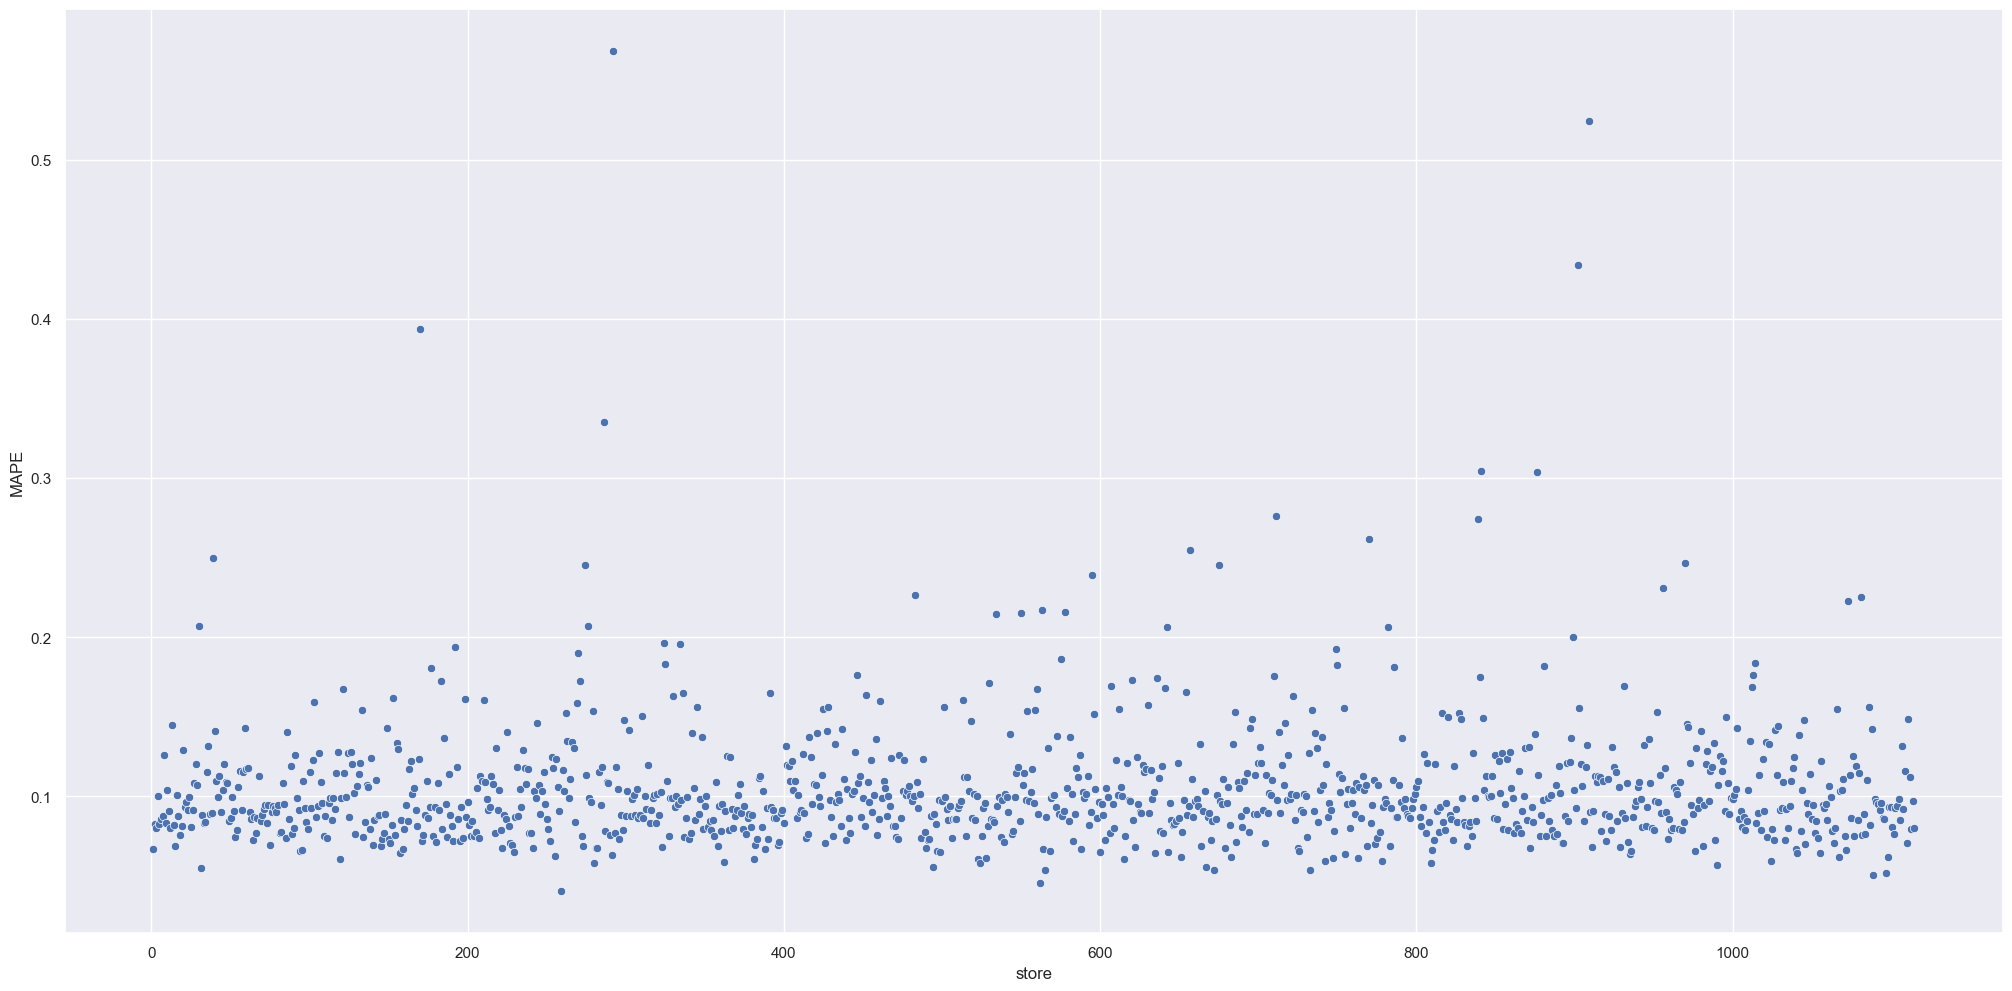

In [134]:
sns.scatterplot(x='store', y='MAPE', data=df9_aux3);

### 9.2. Total performance

In [135]:
df92 = df91[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum(x), axis = 0).reset_index().rename(columns={'index': 'Scenario', 0: 'Values'})
df92['Values'] = df92['Values'].map( 'R${:,.2f}'.format)
df92

,Scenario,Values
0,predictions,"R$283,376,704.00"
1,worst_scenario,"R$254,159,043.55"
2,best_scenario,"R$312,594,380.09"


### 9.3. Machine learning performance

In [136]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

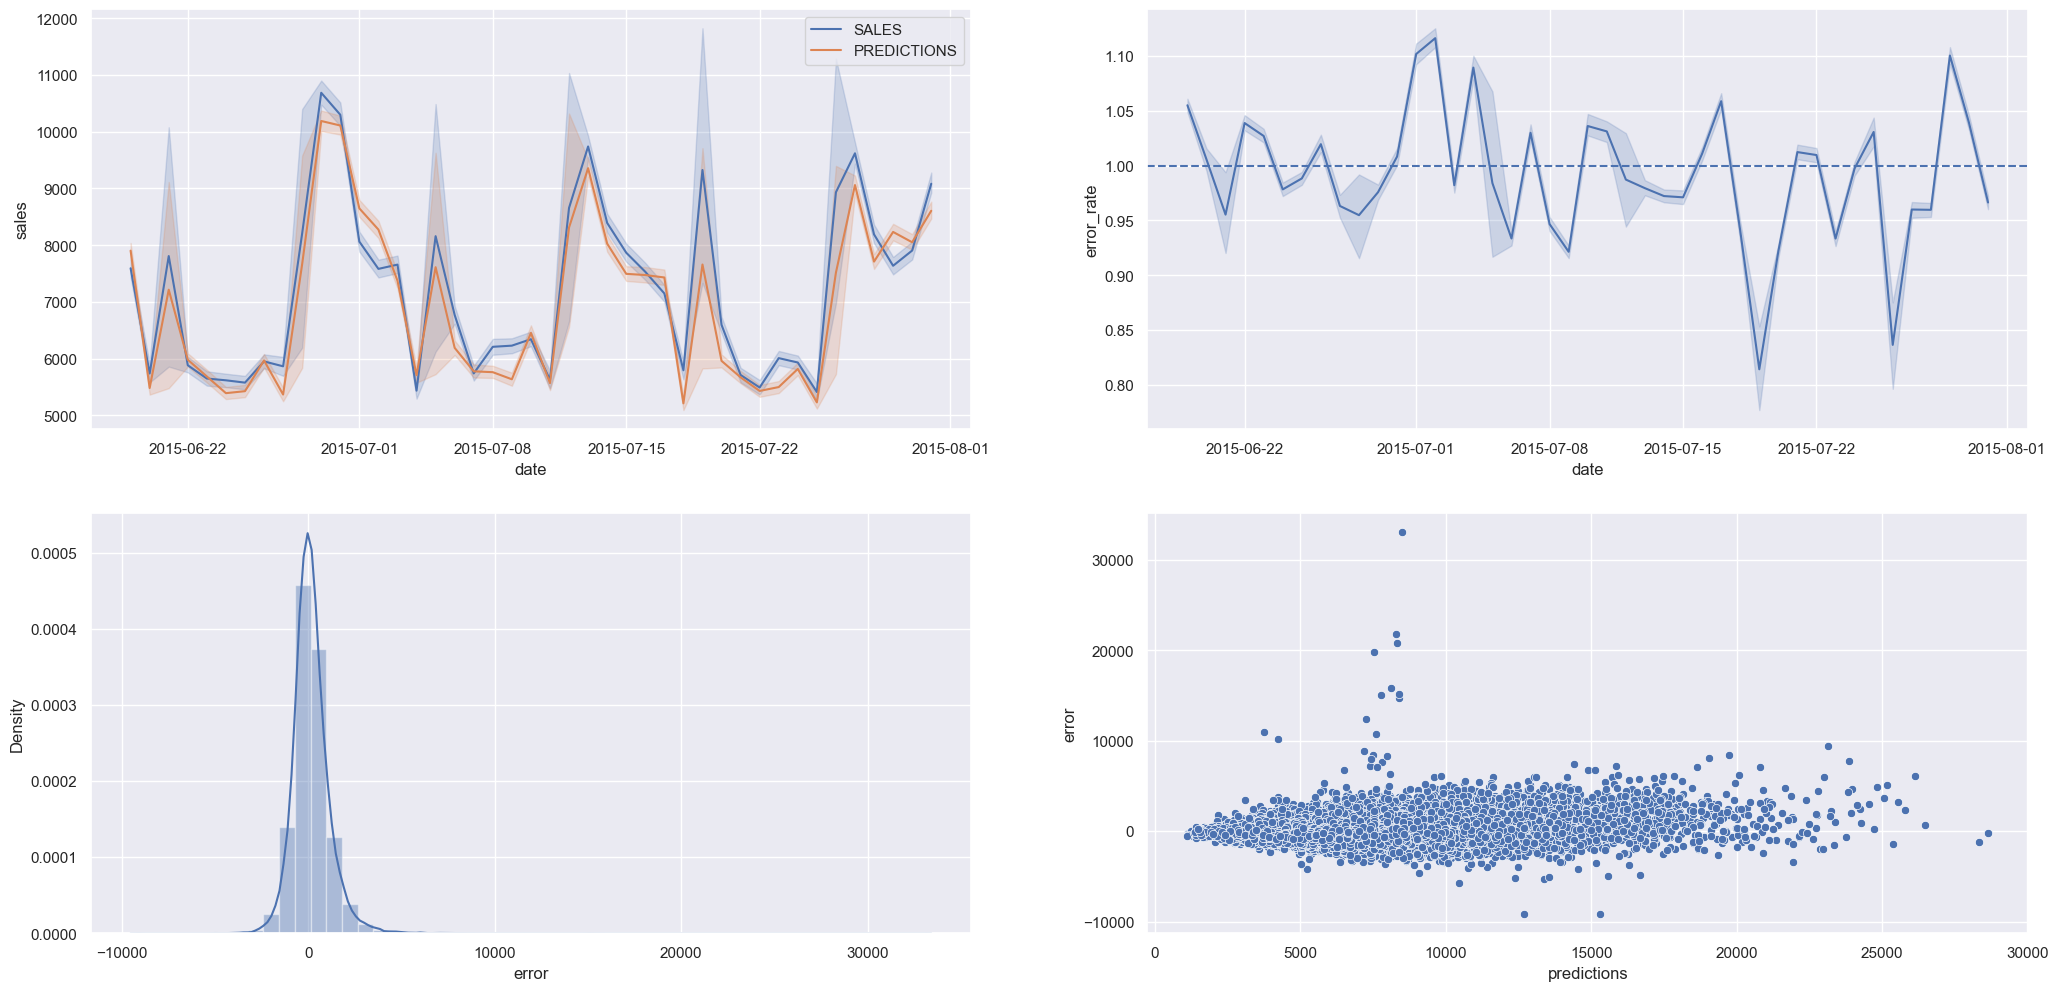

In [137]:
plt.subplot( 2, 2, 1 )
sns.lineplot(x='date', y='sales', data = df9, label='SALES');
sns.lineplot(x='date', y='predictions', data = df9, label='PREDICTIONS');

plt.subplot( 2, 2, 2 )
sns.lineplot(x='date', y='error_rate', data = df9)
plt.axhline(1, linestyle='--');

plt.subplot(2, 2, 3 )
sns.distplot(df9['error']);

plt.subplot(2, 2, 4 )
sns.scatterplot(x = 'predictions', y = 'error', data = df9);

## 10.0. PASSO 10 - Deploy model production

In [ ]:
# Save Trained Model
pickle.dump( model_xgb_tuned, open('model/model_rossmann.pkl', 'wb'))

In [ ]:
pwd!

### 10.1. Rossmann class

In [ ]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann(object):
    def __init__(self):
        self.home_path = ''
        self.competition_distance_scaler =  pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler =              pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler =                  pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler =            pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))
        
    def data_cleaning(self, df1):
        
        old_columns = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                       'CompetitionDistance', 'CompetitionOpenSinceMonth',
                       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                       'Promo2SinceYear', 'PromoInterval']
        
        snakecase = lambda x: inflection.underscore (x)
        new_columns = list(map(snakecase, old_columns))
        
        # rename columns
        df1.columns = new_columns
        
        ### 1.3 Data types
        df1['date'] = pd.to_datetime (df1['date'])

        ### 1.5 Fillout NA
        #competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)
        
        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)
        
        #competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)
        
        #promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)
        
        #promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)
        
        #promo_interval
        month_map = {1: 'Jan',
                     2: 'Feb',
                     3: 'Mar',
                     4: 'Apr',
                     5: 'May',
                     6: 'Jun',
                     7: 'Jul',
                     8: 'Aug',
                     9: 'Sep',
                     10: 'Oct',
                     11: 'Nov',
                     12: 'Dec'}
        
        df1['promo_interval'].fillna(0, inplace = True)
        df1['month_map'] = df1['date'].dt.month.map(month_map)
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

        ### 1.6 Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(np.int64)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(np.int64)
        
        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(np.int64)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(np.int64)
        
        return df1

    def feature_engineering(self, df2):
        
        # year
        df2['year'] = df2['date'].dt.year
        
        # month
        df2['month'] = df2['date'].dt.month
        
        # day
        df2['day'] = df2['date'].dt.day
        
        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype(np.int64)
        
        # year week
        df2['year_week'] = df2['date'].dt.strftime ('%Y-%W')
        
        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'] )/30).apply(lambda x: x.days).astype(np.int64)
        
        # promotion since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days).astype(np.int64)
        
        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
        
        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')
        
        ## Passo 03 - 3.0. FILTRAGEM DE VARIÁVEIS  
        ### 3.1. Filtragem das linhas
        df2 = df2[df2['open'] != 0]
                  
        ### 3.2. Filtragem das colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2

    def data_preparation(self, df5):
        
        # competition_distance
        df5['competition_distance'] = self.competition_distance_scaler.transform (df5[['competition_distance']].values)
        
        # competition_time_month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform (df5[['competition_time_month']].values)
        
        # promo_time_week
        df5['promo_time_week'] = self.promo_time_week_scaler.transform (df5[['promo_time_week']].values)
        
        # year
        df5['year'] = self.year_scaler.transform (df5[['year']].values)
        
        ### 5.3. Transformação
        #### 5.3.1. Encoding
        
        # state_holiday - One hot encoding
        df5 = pd.get_dummies (df5, prefix = ['state_holiday'], columns = ['state_holiday'])
        
        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.transform (df5['store_type'])
        
        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 0, 'extra': 1, 'extended': 2}
        df5['assortment'] = df5['assortment'].map (assortment_dict)
        
        #### 5.3.3. Nature transformation
        # day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply (lambda x: np.sin (x*2*np.pi/7))
        df5['day_of_week_cos'] = df5['day_of_week'].apply (lambda x: np.cos (x*2*np.pi/7))
        
        # month
        df5['month_sin'] = df5['month'].apply (lambda x: np.sin (x*2*np.pi/12))
        df5['month_cos'] = df5['month'].apply (lambda x: np.cos (x*2*np.pi/12))
        
        # day
        df5['day_sin'] = df5['day'].apply (lambda x: np.sin (x*2*np.pi/30))
        df5['day_cos'] = df5['day'].apply (lambda x: np.cos (x*2*np.pi/30))
        
        # week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply (lambda x: np.sin (x*2*np.pi/52))
        df5['week_of_year_cos'] = df5['week_of_year'].apply (lambda x: np.cos (x*2*np.pi/52))
        
        cols_selected = ['store',
                         'promo',
                         'store_type',
                         'assortment',
                         'competition_distance',
                         'competition_open_since_month',
                         'competition_open_since_year',
                         'promo2',
                         'promo2_since_week',
                         'promo2_since_year',
                         'competition_time_month',
                         'promo_time_week',
                         'day_of_week_sin',
                         'day_of_week_cos',
                         'month_cos',
                         'month_sin',
                         'day_sin',
                         'day_cos',
                         'week_of_year_cos',
                         'week_of_year_sin']
        
        return df5[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        
        # prediction
        pred = model.predict(test_data)
        
        # join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        return original_data.to_json(orient='records', date_format='iso')

### 10.2. API Handler

In [ ]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load(open( 'model/model_rossmann.pkl', 'rb') )
# initialize API
app = Flask( __name__ )
@app.route( '/rossmann/predict', methods = ['POST'])

def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
        
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
    
    else:
        return Reponse( '{}', status=200, mimetype='application/json' )
    
if __name__ == '__main__':
    app.run('0.0.0.0')

### 10.3. API tester

In [ ]:
# loading test dataset
df10 = pd.read_csv('datasets/test.csv' )

In [ ]:
# merge test dataset + store
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin([16, 13, 22])]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [ ]:
# convert Dataframe to json
data = json.dumps(df_test.to_dict(orient='records'))

In [ ]:
# API Call
#url = 'http://192.168.1.6:5000/rossmann/predict'
url = 'https://rossmann-sales-predict-j3ri.onrender.com/rossmann/predict'
header = {'Content-type': 'application/json' }
data = data
r = requests.post(url, data = data, headers = header)
print('Status Code {}'.format(r.status_code))

In [ ]:
d1 = pd.DataFrame(r.json(), columns = r.json()[0].keys())

In [ ]:
d1.head()

In [ ]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len( d2 )):
    print('Store Number {} sell prediction is R${:,.2f} in the next 6 weeks'.format(d2.loc[i, 'store'], d2.loc[i, 'prediction']))